## NBA Analytics and Betting Value Analysis Notebook

In [1]:
# -- Cell 1: imports, config, folders -----------------------------------------
import os
import re
import json
import time
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import requests
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Display & randomness
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
np.random.seed(42)

# Folders
DATA_DIR = "data_raw"
DEBUG_DIR = "_rotowire_debug"
EXPORT_DIR = "exports"

for d in (DATA_DIR, DEBUG_DIR, EXPORT_DIR):
    os.makedirs(d, exist_ok=True)

print("✅ Env ready | DATA_DIR:", DATA_DIR, "| DEBUG_DIR:", DEBUG_DIR, "| EXPORT_DIR:", EXPORT_DIR)


✅ Env ready | DATA_DIR: data_raw | DEBUG_DIR: _rotowire_debug | EXPORT_DIR: exports


In [2]:
# -- Cell 2: odds scraper + wide->long helper ---------------------------------
import re
import json
import requests
import pandas as pd
from datetime import datetime

class NBAOddsScraper:
    def __init__(self):
        self.session = requests.Session()
        self.setup_headers()

    def setup_headers(self):
        self.headers = {
            "accept": "*/*",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/130.0.0.0 Safari/537.36",
            "referer": "https://www.rotowire.com/",
        }

    def get_player_props_odds_wide_raw(self, book: str = "mgm") -> pd.DataFrame:
        """
        Pulls the RotoWire player-props page for a single book and extracts all JSON 'data: [...]' blobs.
        Returns a single wide DataFrame with the raw columns RotoWire emits.
        """
        url = f"https://www.rotowire.com/betting/nba/player-props.php?book={book}"
        try:
            r = self.session.get(url, headers=self.headers, timeout=20)
            r.raise_for_status()
        except Exception as e:
            print(f"❌ Failed to GET odds page: {e}")
            return pd.DataFrame()

        matches = re.findall(r"data:\s*(\[\{.*?\}\])", r.text, flags=re.DOTALL)
        frames = []
        for m in matches:
            try:
                rows = json.loads(m)
                if isinstance(rows, list) and rows:
                    frames.append(pd.DataFrame(rows))
            except Exception:
                continue

        if not frames:
            print("⚠️ No odds JSON blocks found.")
            return pd.DataFrame()

        df = pd.concat(frames, ignore_index=True)

        # Normalize a few columns
        base_cols = [c for c in ["name","gameID","playerID","firstName","lastName","team","opp","logo","playerLink"] if c in df.columns]
        other_cols = [c for c in df.columns if c not in base_cols]
        df = df[base_cols + other_cols]

        if "opp" in df.columns and "opponent" not in df.columns:
            df = df.rename(columns={"opp": "opponent"})

        df["asof_date"] = datetime.utcnow().strftime("%Y-%m-%d")
        if "game_date" not in df.columns:
            df["game_date"] = df["asof_date"]
        df["book"] = book

        print(f"✅ Fetched {len(df)} odds rows | {len(df.columns)} columns | book={book}")
        return df

def odds_wide_to_long_from_columns(wide: pd.DataFrame,
                                   books=("mgm","draftkings","fanduel","caesars","betrivers","espnbet","hardrock"),
                                   markets=("PTS","REB","AST")) -> pd.DataFrame:
    """
    Convert the scraped wide odds table into tidy long format:
    columns: player, team, opponent, game_date, market, book, line, over_odds, under_odds
    Works by scanning for patterns like '{book}_{suffix}' where suffix in {'pts','reb','ast'}.
    """
    if wide.empty:
        return pd.DataFrame()

    # base identity cols best-effort
    base_map = {
        "name": "player",
        "team": "team",
        "opponent": "opponent",
        "game_date": "game_date",
    }
    present_keys = [src for src in base_map if src in wide.columns]
    base = wide[present_keys].rename(columns={k: base_map[k] for k in present_keys}).copy()

    rows = []
    suffix_map = {"PTS":"pts","REB":"reb","AST":"ast"}

    for m in markets:
        suf = suffix_map[m]
        for b in books:
            line_col  = f"{b}_{suf}"
            over_col  = f"{b}_{suf}Over"
            under_col = f"{b}_{suf}Under"

            if line_col not in wide.columns:
                continue  # this book-market not present

            # Use get to avoid KeyErrors if over/under missing
            sub = pd.DataFrame({
                "player":   base.get("player", pd.Series([""]*len(wide))),
                "team":     base.get("team", pd.Series([""]*len(wide))),
                "opponent": base.get("opponent", pd.Series([""]*len(wide))),
                "game_date":base.get("game_date", pd.Series([""]*len(wide))),
                "market":   m,
                "book":     b,
                "line":     wide[line_col],
                "over_odds":wide.get(over_col),
                "under_odds":wide.get(under_col),
            })
            rows.append(sub)

    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    # numeric cleaning
    def _num_float(x):
        try:
            if pd.isna(x): return np.nan
            s = str(x).strip()
            if s=="" or s.lower()=="none": return np.nan
            return float(re.search(r"[-+]?\d+(?:\.\d+)?", s).group())
        except Exception:
            return np.nan

    def _num_int(x):
        try:
            if pd.isna(x): return np.nan
            s = str(x).strip()
            if s=="" or s.lower()=="none": return np.nan
            return int(re.search(r"[-+]?\d+", s).group())
        except Exception:
            return np.nan

    if not out.empty:
        out["line"] = out["line"].apply(_num_float)
        if "over_odds" in out.columns:
            out["over_odds"] = out["over_odds"].apply(_num_int)
        if "under_odds" in out.columns:
            out["under_odds"] = out["under_odds"].apply(_num_int)
        out = out.dropna(subset=["line"]).reset_index(drop=True)

    return out

# ---- Run scrape + save -------------------------------------------------------
scraper = NBAOddsScraper()
odds_wide_mgm = scraper.get_player_props_odds_wide_raw(book="mgm")
odds_long = odds_wide_to_long_from_columns(odds_wide_mgm)

print("\n🔎 Long odds preview:")
print(odds_long.head(12).to_string(index=False))

# Save both forms
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
wide_path = f"{DATA_DIR}/rotowire_odds_wide_mgm_{stamp}.csv"
long_path = f"{DATA_DIR}/rotowire_odds_long_mgm_{stamp}.csv"
odds_wide_mgm.to_csv(wide_path, index=False)
odds_long.to_csv(long_path, index=False)
print(f"\n💾 Saved: {wide_path}\n💾 Saved: {long_path}")


✅ Fetched 2009 odds rows | 264 columns | book=mgm

🔎 Long odds preview:
                 player team opponent  game_date market       book  line  over_odds  under_odds
Shai Gilgeous-Alexander  OKC     @SAC 2025-11-07    PTS draftkings  33.5     -111.0      -115.0
  Giannis Antetokounmpo  MIL      CHI 2025-11-07    PTS draftkings  32.5     -119.0      -107.0
        Cade Cunningham  DET     @BKN 2025-11-07    PTS draftkings  28.5     -110.0      -116.0
           Nikola Jokic  DEN      GSW 2025-11-07    PTS draftkings  27.5     -108.0      -118.0
       Donovan Mitchell  CLE     @WAS 2025-11-07    PTS draftkings  27.5     -108.0      -118.0
      Victor Wembanyama  SAS      HOU 2025-11-07    PTS draftkings  25.5     -108.0      -118.0
           Jaylen Brown  BOS     @ORL 2025-11-07    PTS draftkings  25.5     -115.0      -110.0
           Kevin Durant  HOU     @SAS 2025-11-07    PTS draftkings  24.5     -123.0      -104.0
        Anthony Edwards  MIN      UTA 2025-11-07    PTS draftkin

In [3]:
# pip install selenium webdriver-manager bs4 pandas lxml

import os, re, time, pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# ---------------- helpers ----------------

def _clean_list(xs):
    return [re.sub(r"\s+\(.*?\)\s*$", "", x) for x in xs]

def _try_click_consent(driver, timeout=6):
    XPATHS = [
        "//button[contains(.,'Accept')]",
        "//button[contains(.,'I Agree')]",
        "//button[contains(.,'Agree')]",
        "//button[contains(.,'Αποδοχή')]",
        "//button[contains(.,'Συμφωνώ')]",
    ]
    end = time.time() + timeout
    for xp in XPATHS:
        try:
            btn = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, xp)))
            btn.click()
            return True
        except Exception:
            if time.time() > end: break
    return False

def _progress_scroll(driver, steps=10, pause=0.8):
    h = driver.execute_script("return document.body.scrollHeight || document.documentElement.scrollHeight;")
    for i in range(1, steps + 1):
        y = int(h * i / steps)
        driver.execute_script(f"window.scrollTo(0, {y});")
        time.sleep(pause)

def _extract_team(side):
    team_el = side.select_one(".lineup__abbr, .lineup__team-name, .lineup__name")
    if team_el:
        return team_el.get_text(strip=True)
    logo = side.select_one("img[alt]")
    return (logo.get("alt") or "").strip() if logo else ""

def _extract_status(side):
    status_el = side.select_one(".lineup__status")
    txt = (status_el.get_text(" ", strip=True) if status_el else "").upper()
    if "CONFIRM" in txt:  return "CONFIRMED"
    if "EXPECT" in txt or "PROBABLE" in txt: return "EXPECTED"
    return "UNKNOWN"

def _extract_starters(side):
    # Try several variants for starters content
    containers = side.select(".lineup__list--starters, .lineup__list, .lineup__players")
    if not containers:
        containers = [side]

    names = []
    for blk in containers:
        for a in blk.select("a.lineup__player-link, .lineup__player a"):
            t = a.get_text(" ", strip=True)
            if t: names.append(t)
        if not names:
            for row in blk.select(".lineup__player"):
                t = row.get_text(" ", strip=True)
                if re.match(r"^(PG|SG|SF|PF|C)\b", t): names.append(t)
        if not names:
            for li in blk.select("li"):
                t = li.get_text(" ", strip=True)
                if re.match(r"^(PG|SG|SF|PF|C)\b", t): names.append(t)

    if not names:
        txt = side.get_text("\n", strip=True)
        names = re.findall(r"(?:^|\n)(?:PG|SG|SF|PF|C)\s+[^\n]+", txt)

    return _clean_list(names)[:5]

# ---------------- main ----------------

def fetch_rotowire_lineups_selenium(date: str | None = None,
                                    wait_sec: float = 14.0,
                                    headless: bool = False) -> pd.DataFrame:
    """
    Render Rotowire lineups & parse BOTH sides per game (global side selectors).
    Returns:
      game_time, team, side (AWAY/HOME), lineup_status, starters,
      starter_1..starter_5, lineup_confirmed (0/1)
    """
    base = "https://www.rotowire.com/basketball/nba-lineups.php"
    url = base if not date else f"{base}?date={date}"

    opts = Options()
    if headless: opts.add_argument("--headless=new")
    opts.add_argument("--disable-gpu")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument("--window-size=1400,1000")
    opts.add_experimental_option("excludeSwitches", ["enable-automation"])
    opts.add_experimental_option("useAutomationExtension", False)
    opts.add_argument("--disable-blink-features=AutomationControlled")
    opts.add_argument("--lang=en-US,en;q=0.9")
    opts.add_argument(
        "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    )

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=opts)
    driver.get(url)

    _try_click_consent(driver, timeout=6)
    time.sleep(1.2)
    try:
        WebDriverWait(driver, int(wait_sec)).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".lineup, .lineup.is-nba"))
        )
    except Exception:
        pass

    _progress_scroll(driver, steps=10, pause=0.8)
    time.sleep(1.0)

    # quick diagnostics
    blocks = driver.find_elements(By.CSS_SELECTOR, ".lineup.is-nba, .lineup")
    players = driver.find_elements(By.CSS_SELECTOR, ".lineup__player, a.lineup__player-link")
    print(f"diagnostics: lineup blocks={len(blocks)}, player nodes={len(players)}")

    html = driver.page_source
    os.makedirs("_rotowire_debug", exist_ok=True)
    with open("_rotowire_debug/last_lineups.html", "w", encoding="utf-8") as f:
        f.write(html)
    try:
        driver.save_screenshot("_rotowire_debug/last_lineups.png")
    except Exception:
        pass
    driver.quit()

    # -------- parse globally by side classes ----------
    soup = BeautifulSoup(html, "lxml")

    # game time map: find each game container time
    game_time_map = {}
    for gi, g in enumerate(soup.select(".lineup__main, .lineup.is-nba, .lineup")):
        t = g.select_one(".lineup__time, .game-time")
        game_time_map[id(g)] = t.get_text(strip=True) if t else ""

    # Select **visit/away** & **home** side boxes explicitly
    visit_sel = (
        '[class*="lineup__box"][class*="is-visit"], '
        '[class*="lineup__team"][class*="is-visit"], '
        '[class*="lineup__side"][class*="is-visit"], '
        '[class*="visit"]'
    )
    home_sel = (
        '[class*="lineup__box"][class*="is-home"], '
        '[class*="lineup__team"][class*="is-home"], '
        '[class*="lineup__side"][class*="is-home"], '
        '[class*="home"]'
    )

    visit_boxes = soup.select(visit_sel)
    home_boxes  = soup.select(home_sel)

    rows = []

    def add_rows(boxes, side_label):
        for box in boxes:
            # nearest parent game container for time
            parent = box.find_parent(lambda tag: tag.has_attr("class") and any(
                c in {"lineup__main","lineup","lineup is-nba"} for c in tag.get("class", [])
            ))
            game_time = game_time_map.get(id(parent), "") if parent else ""
            team = _extract_team(box)
            starters = _extract_starters(box)
            status = _extract_status(box)
            if starters or team:
                rows.append({
                    "game_time": game_time,
                    "team": team,
                    "side": side_label,
                    "lineup_status": status,
                    "starters": starters,
                    "starter_1": starters[0] if len(starters)>0 else None,
                    "starter_2": starters[1] if len(starters)>1 else None,
                    "starter_3": starters[2] if len(starters)>2 else None,
                    "starter_4": starters[3] if len(starters)>3 else None,
                    "starter_5": starters[4] if len(starters)>4 else None,
                    "lineup_confirmed": int(status == "CONFIRMED"),
                })

    add_rows(visit_boxes, "AWAY")
    add_rows(home_boxes,  "HOME")

    df = pd.DataFrame(rows)

    if not df.empty:
        df = df.drop_duplicates(
            subset=["game_time","team","side","starter_1","starter_2","starter_3","starter_4","starter_5"]
        )
        all_na = df[["starter_1","starter_2","starter_3","starter_4","starter_5"]].isna().all(axis=1)
        df = df[~all_na].reset_index(drop=True)
    else:
        print("⚠️ Parsed zero rows. Check _rotowire_debug/last_lineups.html & .png")

    return df


# ---------- run it ----------
df_lineups = fetch_rotowire_lineups_selenium(wait_sec=14.0, headless=False)
print("✅ Shape:", df_lineups.shape)
print(df_lineups.sort_values(["game_time","side"]).head(12).to_string(index=False))


diagnostics: lineup blocks=14, player nodes=174
✅ Shape: (22, 11)
game_time team side lineup_status                                                                       starters             starter_1     starter_2    starter_3     starter_4      starter_5  lineup_confirmed
               AWAY      EXPECTED        [Derrick White, P. Pritchard, Jaylen Brown, Josh Minott, Neemias Queta]         Derrick White  P. Pritchard Jaylen Brown   Josh Minott  Neemias Queta                 0
               AWAY      EXPECTED               [D. Garland, D. Mitchell, D. Hunter, Evan Mobley, Jarrett Allen]            D. Garland   D. Mitchell    D. Hunter   Evan Mobley  Jarrett Allen                 0
               AWAY      EXPECTED                  [I. Quickley, RJ Barrett, B. Ingram, S. Barnes, Jakob Poeltl]           I. Quickley    RJ Barrett    B. Ingram     S. Barnes   Jakob Poeltl                 0
               AWAY      EXPECTED             [C. Cunningham, D. Robinson, A. Thompson, I. Stewart

In [4]:
# -- Cell 4: parse saved HTML to starters + MNP count --------------------------
import os
import re
import pandas as pd
from bs4 import BeautifulSoup

def _txt(x):
    return re.sub(r"\s+", " ", x.get_text(" ", strip=True)) if x else ""

def _clean_player(n):
    if not n:
        return n
    n = re.sub(r"\s+\(.*?\)\s*$", "", n).strip()
    n = re.sub(r"^(PG|SG|SF|PF|C)\s+", "", n, flags=re.I)
    return n

def _get_mnp_from_ul(ul):
    """Extract 'May Not Play' entries from a team UL."""
    mnp = []
    title = ul.find("li", class_=lambda c: c and "lineup__title" in c and re.search(
        r"may\s+not\s+play", _txt(ul.find("li", class_=c)) if ul.find("li", class_=c) else "", re.I
    ))
    if title:
        for li in title.find_all_next("li"):
            if "lineup__title" in (li.get("class") or []):
                break
            if "lineup__player" in (li.get("class") or []):
                a = li.select_one("a")
                tag = li.select_one(".lineup__inj")
                nm = _txt(a) if a else ""
                if nm:
                    mnp.append(f"{nm} ({_txt(tag)})" if tag else nm)
        return [_clean_player(x) for x in mnp if x and x.lower() != "none"]

    for li in ul.select(".lineup__notplay li, .lineup__status--out, .lineup__inj-list li"):
        nm = _txt(li)
        if nm:
            mnp.append(_clean_player(nm))
    return [x for x in mnp if x and x.lower() != "none"]

def _extract_starters_from_ul(ul):
    names = []
    for li in ul.select("li.lineup__player.is-pct-play-100 a"):
        nm = _txt(li)
        if nm:
            names.append(nm)
    if len(names) < 5:
        for li in ul.select("li.lineup__player a"):
            nm = _txt(li)
            if nm:
                names.append(nm)
            if len(names) >= 5:
                break
    names = [_clean_player(n) for n in names]
    return names[:5]

def _lineup_status(ul):
    st = _txt(ul.select_one(".lineup__status"))
    stU = st.upper()
    if "CONFIRM" in stU: return "CONFIRMED"
    if "EXPECT" in stU or "PROBABLE" in stU: return "EXPECTED"
    return "UNKNOWN"

def parse_rotowire_lineups_flexible(html_path: str) -> pd.DataFrame:
    with open(html_path, "r", encoding="utf-8", errors="ignore") as f:
        html = f.read()
    soup = BeautifulSoup(html, "lxml")

    diag = {
        "lineup__teams": len(soup.select("div.lineup__teams")),
        "ul.lineup__list": len(soup.select("ul.lineup__list")),
        "ul.is-visit": len(soup.select("ul.lineup__list.is-visit")),
        "ul.is-home": len(soup.select("ul.lineup__list.is-home")),
        "see-proj-minutes buttons": len(soup.select("button.see-proj-minutes")),
        "header abbr": len(soup.select(".lineup__hdr .lineup__abbr")),
        "header team": len(soup.select(".lineup__hdr .lineup__team")),
        "player anchors": len(soup.select("a.lineup__player-link, .lineup__player a")),
        "MNP titles": len(soup.find_all(string=re.compile(r"^\s*may\s+not\s+play\s*$", re.I))),
    }
    print("DOM diagnostics:", diag)

    rows = []

    # Strategy A: by matchup blocks
    for teams_div in soup.select("div.lineup__teams"):
        time_el = teams_div.find_previous("div", class_="lineup__time")
        game_time = _txt(time_el)

        uls = teams_div.select("ul.lineup__list")
        if len(uls) < 1:
            continue

        away_ul = None
        home_ul = None
        for ul in uls:
            classes = " ".join(ul.get("class", [])).lower()
            if "is-visit" in classes or "visit" in classes or "away" in classes:
                away_ul = ul
            if "is-home" in classes or "home" in classes:
                home_ul = home_ul or ul

        if away_ul is None and home_ul is None and len(uls) >= 2:
            away_ul, home_ul = uls[0], uls[1]
        elif away_ul is None and len(uls) >= 1:
            away_ul = uls[0]
        elif home_ul is None and len(uls) >= 2:
            home_ul = next((u for u in uls if u is not away_ul), None)

        header_abbrs = [_txt(el) for el in teams_div.select(".lineup__abbr") if _txt(el)]
        if not header_abbrs:
            parent_main = teams_div.find_parent(["div","section"])
            if parent_main:
                header_abbrs = [_txt(el) for el in parent_main.select(".lineup__abbr") if _txt(el)]

        for idx, (side, ul) in enumerate([("AWAY", away_ul), ("HOME", home_ul)]):
            if not ul:
                continue
            btn = ul.select_one("button.see-proj-minutes")
            team = btn["data-team"].strip().upper() if btn and btn.has_attr("data-team") else None
            if not team and header_abbrs and idx < len(header_abbrs):
                team = header_abbrs[idx].upper()

            starters = _extract_starters_from_ul(ul)
            mnp = _get_mnp_from_ul(ul)
            status = _lineup_status(ul)

            if team or starters or mnp:
                rows.append({
                    "game_time": game_time,
                    "team": team,
                    "side": side,
                    "lineup_status": status,
                    "starters": starters,
                    "may_not_play": mnp,
                    "may_not_play_count": len(mnp),
                    "lineup_confirmed": int(status == "CONFIRMED"),
                })

    # Strategy B: global scan if A found nothing
    if not rows:
        print("Fallback B: scanning all ul.lineup__list globally...")
        for ul in soup.select("ul.lineup__list"):
            side = "AWAY" if "is-visit" in (ul.get("class") or []) else ("HOME" if "is-home" in (ul.get("class") or []) else None)
            btn = ul.select_one("button.see-proj-minutes")
            team = btn["data-team"].strip().upper() if btn and btn.has_attr("data-team") else None
            starters = _extract_starters_from_ul(ul)
            mnp = _get_mnp_from_ul(ul)
            status = _lineup_status(ul)

            if side and (team or starters or mnp):
                rows.append({
                    "game_time": "",
                    "team": team,
                    "side": side,
                    "lineup_status": status,
                    "starters": starters,
                    "may_not_play": mnp,
                    "may_not_play_count": len(mnp),
                    "lineup_confirmed": int(status == "CONFIRMED"),
                })

    df = pd.DataFrame(rows)
    for i in range(5):
        col = f"starter_{i+1}"
        if "starters" in df.columns:
            df[col] = df["starters"].apply(lambda xs: xs[i] if isinstance(xs, list) and len(xs) > i else None)

    print(f"→ Parsed rows: {len(df)}")

    # Save a copy for downstream
    stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out_path = f"{DATA_DIR}/lineups_parsed_{stamp}.csv"
    df.to_csv(out_path, index=False)
    print(f"💾 Saved parsed lineups to {out_path}")

    return df

# ---- RUN IT (point to the saved HTML) ----
HTML_PATH = f"{DEBUG_DIR}/last_lineups.html"
if not os.path.exists(HTML_PATH) and os.path.exists("last_lineups.html"):
    HTML_PATH = "last_lineups.html"

df_lineups = parse_rotowire_lineups_flexible(HTML_PATH)

if df_lineups.empty:
    print("\n⚠️ Still empty. Check DOM diagnostics and ensure Cell 3 ran successfully.")
else:
    cols = ["game_time","team","side","lineup_status","may_not_play_count",
            "starter_1","starter_2","starter_3","starter_4","starter_5"]
    print("\n✅ Preview:")
    print(df_lineups[cols].sort_values(["game_time","side","team"], na_position="last").to_string(index=False))


DOM diagnostics: {'lineup__teams': 11, 'ul.lineup__list': 22, 'ul.is-visit': 11, 'ul.is-home': 11, 'see-proj-minutes buttons': 22, 'header abbr': 0, 'header team': 0, 'player anchors': 174, 'MNP titles': 22}
Fallback B: scanning all ul.lineup__list globally...
→ Parsed rows: 22
💾 Saved parsed lineups to data_raw/lineups_parsed_20251107_104528.csv

✅ Preview:
game_time team side lineup_status  may_not_play_count             starter_1        starter_2      starter_3        starter_4             starter_5
           BOS AWAY      EXPECTED                   7         Derrick White     P. Pritchard   Jaylen Brown      Josh Minott         Neemias Queta
           CHA AWAY      EXPECTED                  10          Kon Knueppel    Miles Bridges R. Kalkbrenner          L. Ball             C. Sexton
           CHI AWAY      EXPECTED                   8             Tre Jones      Josh Giddey    Isaac Okoro    Matas Buzelis            N. Vucevic
           CLE AWAY      EXPECTED                  

In [5]:
# -- Cell 5: Parse "May Not Play" (MNP) from saved HTML -----------------------
# pip install bs4 lxml pandas
import os, re, pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

# Folders (fallbacks, in case Cell 1 wasn't run)
DATA_DIR = "data_raw"; DEBUG_DIR = "_rotowire_debug"
os.makedirs(DATA_DIR, exist_ok=True); os.makedirs(DEBUG_DIR, exist_ok=True)

HTML_PATH = f"{DEBUG_DIR}/last_lineups.html" if os.path.exists(f"{DEBUG_DIR}/last_lineups.html") else "last_lineups.html"

LIKELIHOOD_MAP = {
    "is-pct-play-100": 100, "is-pct-play-90": 90, "is-pct-play-75": 75,
    "is-pct-play-60": 60, "is-pct-play-50": 50, "is-pct-play-40": 40,
    "is-pct-play-25": 25, "is-pct-play-10": 10, "is-pct-play-0": 0
}

def _txt(node): 
    return re.sub(r"\s+", " ", node.get_text(" ", strip=True)) if node else ""

def _likelihood_from_classes(classes):
    for c in classes or []:
        if c in LIKELIHOOD_MAP:
            return LIKELIHOOD_MAP[c]
    return None

def _clean_player(n):
    if not n: return n
    n = re.sub(r"\s+\(.*?\)\s*$", "", n).strip()
    n = re.sub(r"^(PG|SG|SF|PF|C)\s+", "", n, flags=re.I)
    return n

def parse_rotowire_mnp_final(html_path: str) -> pd.DataFrame:
    with open(html_path, "r", encoding="utf-8", errors="ignore") as f:
        soup = BeautifulSoup(f.read(), "lxml")

    rows = []

    # Primary structure
    games = soup.select("div.lineup.is-nba[data-lnum]")
    print(f"Found {len(games)} games in HTML.")

    for game in games:
        game_time = _txt(game.select_one(".lineup__time"))
        # Pair teams by .lineup__team, then iterate their ULs
        team_blocks = game.select(".lineup__team")
        teams = []
        for tb in team_blocks:
            abbr = _txt(tb.select_one(".lineup__abbr")) or _txt(tb.select_one(".lineup__team-name"))
            side = "AWAY" if "is-visit" in (tb.get("class") or []) else ("HOME" if "is-home" in (tb.get("class") or []) else None)
            teams.append((abbr, side))

        ul_lists = game.select("ul.lineup__list")
        for idx, ul in enumerate(ul_lists):
            team, side = (teams[idx] if idx < len(teams) else (None, None))
            # Find the MNP title in this UL
            mnp_title = ul.find("li", class_="lineup__title", string=lambda s: s and "MAY NOT PLAY" in s.upper())
            if not mnp_title:
                continue

            for li in mnp_title.find_next_siblings("li"):
                classes = li.get("class") or []
                if "lineup__title" in classes:
                    break
                if "lineup__player" not in classes:
                    continue

                pos = _txt(li.select_one(".lineup__pos"))
                a = li.select_one("a")
                player = _clean_player(_txt(a))
                if not player:
                    continue

                status = _txt(li.select_one(".lineup__inj"))
                title_text = (li.get("title") or "").strip()
                likelihood_pct = _likelihood_from_classes(classes)

                rows.append({
                    "game_time": game_time,
                    "team": team,
                    "side": side,
                    "position": pos,
                    "player": player,
                    "status": status,
                    "title_text": title_text,
                    "likelihood_pct": likelihood_pct
                })

    # Fallback: global scan (if nothing found in primary structure)
    if not rows:
        print("Fallback: global MNP scan…")
        for ul in soup.select("ul.lineup__list"):
            title = ul.find("li", class_="lineup__title", string=lambda s: s and "MAY NOT PLAY" in s.upper())
            if not title:
                continue
            for li in title.find_next_siblings("li"):
                classes = li.get("class") or []
                if "lineup__title" in classes:
                    break
                if "lineup__player" not in classes:
                    continue
                player = _clean_player(_txt(li.select_one("a")))
                if not player:
                    continue
                rows.append({
                    "game_time": "",
                    "team": None,
                    "side": None,
                    "position": _txt(li.select_one(".lineup__pos")),
                    "player": player,
                    "status": _txt(li.select_one(".lineup__inj")),
                    "title_text": (li.get("title") or "").strip(),
                    "likelihood_pct": _likelihood_from_classes(classes)
                })

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No 'May Not Play' players found. Check if Rotowire changed markup or re-run Cell 3.")
        return df

    df = df.sort_values(["game_time","side","team","player"], na_position="last").reset_index(drop=True)
    print(f"✅ Parsed {len(df)} 'May Not Play' players across {df['team'].nunique(dropna=True)} teams.")
    return df

# ---- RUN ----
mnp_df = parse_rotowire_mnp_final(HTML_PATH)
if not mnp_df.empty:
    print(mnp_df.head(30).to_string(index=False))
    stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out_csv = f"{DATA_DIR}/may_not_play_players_{stamp}.csv"
    mnp_df.to_csv(out_csv, index=False)
    print(f"\n💾 Saved: {out_csv}")


Found 11 games in HTML.
✅ Parsed 64 'May Not Play' players across 21 teams.
  game_time team side position          player status            title_text  likelihood_pct
10:00 PM ET  GSW AWAY        C        D. Green   Prob        Likely To Play              75
10:00 PM ET  GSW AWAY        G       D. Melton    Out Very Unlikely To Play               0
10:00 PM ET  GSW AWAY        F       J. Butler   Ques       Toss Up To Play              50
10:00 PM ET  GSW AWAY        G        S. Curry    Out Very Unlikely To Play               0
10:00 PM ET  OKC AWAY        F      A. Wiggins    Out Very Unlikely To Play               0
10:00 PM ET  OKC AWAY        F     J. Williams    Out Very Unlikely To Play               0
10:00 PM ET  OKC AWAY        F     K. Williams    Out Very Unlikely To Play               0
10:00 PM ET  OKC AWAY        F         L. Dort   Ques       Toss Up To Play              50
10:00 PM ET  OKC AWAY        G        N. Topic    Out Very Unlikely To Play               0
10:0

In [6]:
#-- Cell 6: NBA betting analysis functions -------------------------------------
def get_daily_matchups(date=None):
    """Get NBA games for a specific date"""
    if date is None:
        date = datetime.now().strftime('%Y-%m-%d')
    # Placeholder demo; replace with a real schedule API if desired
    sample_matchups = [
        {'home_team': 'GSW', 'away_team': 'LAL', 'time': '7:30 PM ET'},
        {'home_team': 'BOS', 'away_team': 'MIA', 'time': '8:00 PM ET'},
        {'home_team': 'DEN', 'away_team': 'DAL', 'time': '9:00 PM ET'},
    ]
    return sample_matchups

def calculate_player_correlations(player_a_logs, player_b_logs):
    """Calculate correlation between two players' performances"""
    merged = pd.merge(player_a_logs, player_b_logs, on='GAME_DATE', suffixes=('_a', '_b'))
    correlations = {}
    for stat in ['PTS', 'REB', 'AST']:
        if f'{stat}_a' in merged.columns and f'{stat}_b' in merged.columns:
            corr = merged[f'{stat}_a'].corr(merged[f'{stat}_b'])
            correlations[stat] = corr
    return correlations

# Export results to Excel
def export_analysis(results, filename='nba_betting_analysis.xlsx'):
    """Export analysis results to Excel"""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        if 'value_bets' in results:
            pd.DataFrame(results['value_bets']).to_excel(writer, sheet_name='Value_Bets', index=False)
        if 'predictions' in results:
            predictions_df = pd.DataFrame.from_dict(results['predictions'], orient='index')
            predictions_df.to_excel(writer, sheet_name='Player_Predictions')
    print(f"Analysis exported to {filename}")


In [7]:
# -- Cell 7: starter flags (time-aware) + injury flags ------------------------
from datetime import datetime, timedelta
import pytz
import numpy as np
import pandas as pd
import os

# Folders (fallbacks, in case Cell 1 wasn't run)
DATA_DIR = "data_raw"; os.makedirs(DATA_DIR, exist_ok=True)

def compute_time_based_prob(game_time_str: str, lineup_status: str) -> float:
    """Rough start probability based on status and hours to tip (ET)."""
    try:
        if not game_time_str:
            return 0.7
        game_time_clean = game_time_str.replace("ET", "").strip()
        base_dt = datetime.strptime(game_time_clean, "%I:%M %p")
        now_et = datetime.now(pytz.timezone("US/Eastern"))
        game_dt = now_et.replace(hour=base_dt.hour, minute=base_dt.minute, second=0, microsecond=0)
        hours_to_tip = (game_dt - now_et).total_seconds() / 3600.0
        if hours_to_tip < -3:
            game_dt += timedelta(days=1)
            hours_to_tip = (game_dt - now_et).total_seconds() / 3600.0
    except Exception:
        hours_to_tip = 6.0

    st = (lineup_status or "").upper()
    if "CONFIRM" in st:
        return 1.0
    if "EXPECT" in st or "PROBABLE" in st:
        if hours_to_tip > 6: return 0.70
        if hours_to_tip > 2: return 0.85
        return 0.95
    # unknown
    return 0.60 if hours_to_tip > 4 else 0.80

def build_starter_flags_timeaware(df_lineups: pd.DataFrame, mnp_df: pd.DataFrame) -> pd.DataFrame:
    """From df_lineups (with 'starters' list per row), emit per-player start_prob."""
    mnp_players = set(mnp_df["player"].str.strip()) if (isinstance(mnp_df, pd.DataFrame) and not mnp_df.empty) else set()
    rows = []

    if df_lineups is None or df_lineups.empty or "starters" not in df_lineups.columns:
        return pd.DataFrame(columns=["player","team","is_starter","start_prob"])

    for _, row in df_lineups.iterrows():
        team = row.get("team", None)
        lineup_status = row.get("lineup_status", "")
        game_time = row.get("game_time", "")
        starters = row.get("starters", [])
        starters = starters if isinstance(starters, list) else []

        for p in starters:
            p_clean = (p or "").strip()
            if not p_clean:
                continue
            prob = compute_time_based_prob(game_time, lineup_status)
            if p_clean in mnp_players:
                prob *= 0.6  # penalize if on MNP
            rows.append({
                "player": p_clean,
                "team": team,
                "is_starter": 1,
                "start_prob": round(float(np.clip(prob, 0.0, 1.0)), 2),
            })

    df_out = pd.DataFrame(rows).drop_duplicates(subset=["player"])
    print(f"✅ Created {len(df_out)} starter probability rows.")
    return df_out

def build_injury_flags(mnp_df: pd.DataFrame) -> pd.DataFrame:
    if mnp_df is None or mnp_df.empty:
        return pd.DataFrame(columns=["player","may_not_play","injury_prob"])
    return (
        mnp_df.dropna(subset=["player"])
              .assign(
                  player=lambda d: d["player"].str.strip(),
                  injury_prob=lambda d: d["likelihood_pct"].fillna(40) / 100.0,
                  may_not_play=1
              )[["player","may_not_play","injury_prob"]]
              .drop_duplicates(subset=["player"])
    )

# ---- RUN (expects df_lineups from Cell 3 and mnp_df from Cell 5) ------------
starter_flags_df = build_starter_flags_timeaware(df_lineups, mnp_df)
injury_flags_df = build_injury_flags(mnp_df)

print("✅ Starter flags sample:")
print(starter_flags_df.head(10).to_string(index=False))

print("\n✅ Injury flags sample:")
print(injury_flags_df.head(10).to_string(index=False))

# Save outputs
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
sf_path  = f"{DATA_DIR}/starter_flags_{stamp}.csv"
inj_path = f"{DATA_DIR}/injury_flags_{stamp}.csv"
starter_flags_df.to_csv(sf_path, index=False)
injury_flags_df.to_csv(inj_path, index=False)
print(f"\n💾 Saved starter flags → {sf_path}\n💾 Saved injury flags → {inj_path}")


✅ Created 101 starter probability rows.
✅ Starter flags sample:
       player team  is_starter  start_prob
Derrick White  BOS           1         0.7
 P. Pritchard  BOS           1         0.7
 Jaylen Brown  BOS           1         0.7
  Josh Minott  BOS           1         0.7
Neemias Queta  BOS           1         0.7
  Jalen Suggs  ORL           1         0.7
 Desmond Bane  ORL           1         0.7
 Franz Wagner  ORL           1         0.7
  P. Banchero  ORL           1         0.7
    W. Carter  ORL           1         0.7

✅ Injury flags sample:
     player  may_not_play  injury_prob
   D. Green             1         0.75
  D. Melton             1         0.00
  J. Butler             1         0.50
   S. Curry             1         0.00
 A. Wiggins             1         0.00
J. Williams             1         0.00
K. Williams             1         0.00
    L. Dort             1         0.50
   N. Topic             1         0.00
  T. Sorber             1         0.00

💾 Saved s

## NBA

In [8]:
# -- Cell 8: Download per-season player stats from NBA Stats API --------------
# (Be polite: retries + small random delays)
import os, time, random, requests, pandas as pd
from datetime import datetime

# Folders (fallbacks)
DATA_DIR = "data_raw"; os.makedirs(DATA_DIR, exist_ok=True)

URL = "https://stats.nba.com/stats/leaguedashplayerstats"

BASE_PARAMS = {
    "College": "", "Conference": "", "Country": "", "DateFrom": "", "DateTo": "",
    "Division": "", "DraftPick": "", "DraftYear": "", "GameScope": "", "GameSegment": "",
    "Height": "", "ISTRound": "", "LastNGames": "0", "LeagueID": "00", "Location": "",
    "MeasureType": "Base", "Month": "0", "OpponentTeamID": "0", "Outcome": "",
    "PORound": "0", "PaceAdjust": "N", "PerMode": "PerGame", "Period": "0",
    "PlayerExperience": "", "PlayerPosition": "", "PlusMinus": "N", "Rank": "N",
    "SeasonSegment": "", "SeasonType": "Regular Season", "ShotClockRange": "",
    "StarterBench": "", "TeamID": "0", "VsConference": "", "VsDivision": "", "Weight": ""
}

HEADERS = {
    "Accept": "application/json, text/plain, */*",
    "Accept-Language": "en-US,en;q=0.9",
    "Origin": "https://www.nba.com",
    "Referer": "https://www.nba.com/",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true"
}

SEASONS = ["2023-24", "2024-25"]

def fetch_season(season: str, retries: int = 3) -> pd.DataFrame:
    params = BASE_PARAMS.copy()
    params["Season"] = season
    for attempt in range(1, retries + 1):
        try:
            print(f"→ Attempt {attempt} fetching {season}…")
            r = requests.get(URL, headers=HEADERS, params=params, timeout=30)
            r.raise_for_status()
            js = r.json()
            rs = js["resultSets"][0]
            df = pd.DataFrame(rs["rowSet"], columns=rs["headers"])
            return df
        except requests.exceptions.Timeout:
            print(f"⚠️ Timeout {attempt}/{retries}; retrying…")
            time.sleep(2 * attempt)
        except requests.exceptions.RequestException as e:
            print(f"❌ Error {attempt}/{retries}: {e}"); time.sleep(2 * attempt)
    raise RuntimeError(f"Failed to fetch {season} after {retries} attempts.")

all_paths = []
for season in SEASONS:
    print(f"\n🏀 Fetching NBA stats for {season}…")
    df = fetch_season(season)
    path = f"{DATA_DIR}/nba_player_stats_{season.replace('-','_')}.csv"
    df.to_csv(path, index=False)
    print(f"✅ {season}: saved {len(df)} rows → {path}")
    all_paths.append(path)
    time.sleep(random.uniform(3, 6))  # throttle politely

print("\n🎉 Done! Saved:", all_paths)



🏀 Fetching NBA stats for 2023-24…
→ Attempt 1 fetching 2023-24…
✅ 2023-24: saved 572 rows → data_raw/nba_player_stats_2023_24.csv

🏀 Fetching NBA stats for 2024-25…
→ Attempt 1 fetching 2024-25…
✅ 2024-25: saved 569 rows → data_raw/nba_player_stats_2024_25.csv

🎉 Done! Saved: ['data_raw/nba_player_stats_2023_24.csv', 'data_raw/nba_player_stats_2024_25.csv']


## GAME LOGS

In [9]:
# -- Cell 9: Download player game logs (box scores) by season ------------------
import os, time, requests, pandas as pd
from datetime import datetime

# Folders (fallbacks)
DATA_DIR = "data_raw"; os.makedirs(DATA_DIR, exist_ok=True)

def get_box_scores(season: str, season_type: str = "Regular Season") -> pd.DataFrame:
    url = "https://stats.nba.com/stats/leaguegamelog"
    params = {
        "Counter": 1000, "DateFrom": "", "DateTo": "", "Direction": "DESC",
        "ISTRound": "", "LeagueID": "00", "PlayerOrTeam": "P",
        "Season": season, "SeasonType": season_type, "Sorter": "DATE"
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
        "Referer": "https://www.nba.com/", "Origin": "https://www.nba.com",
        "Accept": "application/json, text/plain, */*"
    }
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    data = r.json()["resultSets"][0]
    df = pd.DataFrame(data["rowSet"], columns=data["headers"])
    return df

SEASONS = ["2025-26"]
# already saved once season: ["2023-24", "2024-25"]
saved = []
for season in SEASONS:
    print(f"Fetching {season}…")
    df = get_box_scores(season)
    path = f"{DATA_DIR}/nba_boxscores_{season}.csv"
    df.to_csv(path, index=False)
    print(f"✅ Saved {len(df)} records → {path}")
    saved.append(path)
    time.sleep(2)  # polite delay

print("\n🎉 Box score downloads complete.")


Fetching 2025-26…
✅ Saved 2724 records → data_raw/nba_boxscores_2025-26.csv

🎉 Box score downloads complete.


In [10]:
# -- Cell 10: Fetch BBRef Advanced tables, align, and enrich season CSVs -------
import os, io, unicodedata, requests, pandas as pd
from datetime import datetime

# Folders (work even if Cell 1 didn't run)
DATA_DIR   = "data_raw"
ENRICH_DIR = "data_enriched"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(ENRICH_DIR, exist_ok=True)

ADV_COLS_KEEP = [
    "Player","Pos","Age","Tm","G","MP",
    "PER","TS%","3PAr","FTr",
    "ORB%","DRB%","TRB%",
    "AST%","STL%","BLK%",
    "TOV%","USG%",
    "ORtg","DRtg",
    "OWS","DWS","WS","WS/48",
    "OBPM","DBPM","BPM","VORP"
]

TEAM_ABBR_MAP = {
    "BRK": "BKN",
    "PHO": "PHX",
    "CHO": "CHA",
    "UTH": "UTA",
    "NJN": "BKN",
    "SEA": "OKC",
    "VAN": "MEM",
}

def normalize_name(s: str):
    if pd.isna(s): return s
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    for ch in [".","'","`","’","“","”",","]:
        s = s.replace(ch, "")
    return " ".join(s.split())

def fetch_advanced_table(season_end_year: int, retries: int = 3) -> pd.DataFrame:
    """
    season_end_year=2025 -> https://www.basketball-reference.com/leagues/NBA_2025_advanced.html
    """
    url = f"https://www.basketball-reference.com/leagues/NBA_{season_end_year}_advanced.html"
    headers = {
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/120.0.0.0 Safari/537.36")
    }
    last_err = None
    for attempt in range(1, retries+1):
        try:
            r = requests.get(url, headers=headers, timeout=30)
            r.raise_for_status()
            tables = pd.read_html(io.StringIO(r.text), header=0)
            if not tables:
                raise RuntimeError("No tables parsed from page.")
            df = tables[0].copy()
            # Drop duplicate header rows
            if "Rk" in df.columns:
                df = df[df["Rk"] != "Rk"].copy()
                df.drop(columns=["Rk"], inplace=True, errors="ignore")
            df.columns = [c.strip() for c in df.columns]

            # Ensure team column name
            team_col = None
            for c in df.columns:
                if c.lower() in ("tm","team","team_name"):
                    team_col = c; break
            if not team_col:
                raise KeyError(f"Team column not found. Columns: {df.columns.tolist()}")
            df.rename(columns={team_col: "Tm"}, inplace=True)

            keep = [c for c in ADV_COLS_KEEP if c in df.columns]
            df = df[keep].copy()

            for c in df.columns:
                if c not in {"Player","Pos","Tm"}:
                    df[c] = pd.to_numeric(df[c], errors="coerce")

            df["Tm"] = df["Tm"].replace(TEAM_ABBR_MAP)
            df["player_key"] = df["Player"].map(normalize_name)
            df["team_key"] = df["Tm"].astype(str).str.strip().str.upper()
            return df
        except Exception as e:
            last_err = e
    raise last_err

def load_averages_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # map columns to canonical 'Player' and 'Team'
    col_map = {}
    for c in df.columns:
        cl = c.strip().lower()
        if cl == "player_name": col_map[c] = "Player"
        elif cl in ("team_abbreviation","tm","team"): col_map[c] = "Team"
    df = df.rename(columns=col_map)
    if "Player" not in df.columns or "Team" not in df.columns:
        raise ValueError(f"'Player' and 'Team' required. Got: {list(df.columns)}")
    df["player_key"] = df["Player"].map(normalize_name)
    df["team_key"]   = df["Team"].astype(str).str.strip().str.upper()
    return df

def merge_advanced_into_averages(df_avg: pd.DataFrame, df_adv: pd.DataFrame) -> pd.DataFrame:
    adv_team = df_adv[df_adv["Tm"] != "TOT"].copy()
    adv_tot  = df_adv[df_adv["Tm"] == "TOT"].copy()

    adv_cols = [c for c in df_adv.columns if c not in {"Player","Pos","Age","Tm","player_key","team_key"}]
    meta_cols = [c for c in ["Pos","Age"] if c in df_adv.columns]
    add_cols = meta_cols + adv_cols

    merged = df_avg.merge(
        adv_team[["player_key","team_key"] + add_cols],
        on=["player_key","team_key"], how="left"
    )

    # Fill gaps from TOT by player
    probe = "PER" if "PER" in merged.columns else ("WS/48" if "WS/48" in merged.columns else None)
    missing = merged[probe].isna() if probe else merged.isna().any(axis=1)
    if missing.any() and not adv_tot.empty:
        fb = merged.loc[missing, ["player_key"]].merge(
            adv_tot[["player_key"] + add_cols], on="player_key", how="left"
        )
        for col in add_cols:
            if col in merged.columns and col in fb.columns:
                merged.loc[missing, col] = merged.loc[missing, col].fillna(fb[col])
    return merged

# --- Build both seasons and save into ENRICH_DIR ------------------------------
# Map: "2023-24" -> 2024, "2024-25" -> 2025
pairs = [
    ("2023_24", 2024),
    ("2024_25", 2025),
]
out_paths = []
for tag, yr in pairs:
    avg_path = os.path.join(DATA_DIR, f"nba_player_stats_{tag}.csv")
    if not os.path.exists(avg_path):
        raise FileNotFoundError(f"Missing averages CSV: {avg_path}. Run Cell 8 first.")
    df_avg = load_averages_csv(avg_path)
    df_adv = fetch_advanced_table(yr)
    df_enriched = merge_advanced_into_averages(df_avg, df_adv)

    outp = os.path.join(ENRICH_DIR, f"nba_player_stats_{tag}_enriched.csv")
    df_enriched.to_csv(outp, index=False)
    print(f"✅ Saved: {outp}")
    out_paths.append(outp)

# Optional combined
combined = pd.concat([pd.read_csv(p) for p in out_paths], ignore_index=True)
combined.to_csv(os.path.join(ENRICH_DIR, "nba_player_stats_2023_25_combined.csv"), index=False)
print("🏀 Combined →", os.path.join(ENRICH_DIR, "nba_player_stats_2023_25_combined.csv"))


✅ Saved: data_enriched\nba_player_stats_2023_24_enriched.csv
✅ Saved: data_enriched\nba_player_stats_2024_25_enriched.csv
🏀 Combined → data_enriched\nba_player_stats_2023_25_combined.csv


In [11]:
# -- Cell 11: Game-log → features (rolling, team ratings, opponent allowances) -
import numpy as np
import pandas as pd

def standardize_logs_cols(df_logs: pd.DataFrame) -> pd.DataFrame:
    colmap = {}
    for c in df_logs.columns:
        cl = c.strip().lower()
        if cl in {"game_date","game_date_est","date"}: colmap[c] = "GAME_DATE"
        elif cl in {"player","player_name"}: colmap[c] = "PLAYER_NAME"
        elif cl in {"team","team_abbreviation","tm"}: colmap[c] = "TEAM_ABBREVIATION"
        elif cl in {"opp","opponent","opponent_abbreviation"}: colmap[c] = "OPPONENT_ABBREVIATION"
        elif cl in {"min","minutes"}: colmap[c] = "MIN"
    df = df_logs.rename(columns=colmap).copy()
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    df = df.sort_values(["PLAYER_NAME","GAME_DATE"])
    return df

def add_shooting_efficiency(df: pd.DataFrame) -> pd.DataFrame:
    for col in ["FGA","FTA","PTS"]:
        if col not in df.columns: df[col] = 0.0
    denom = 2 * (df["FGA"].astype(float) + 0.44 * df["FTA"].astype(float))
    df["TS_game"] = np.where(denom > 0, df["PTS"].astype(float)/denom, np.nan)
    return df

def rolling_player_form(df: pd.DataFrame, windows=(3,5,10,20)) -> pd.DataFrame:
    df = df.sort_values(["PLAYER_NAME","GAME_DATE"]).copy()
    g = df.groupby("PLAYER_NAME", group_keys=False)
    for w in windows:
        for stat in ["PTS","REB","AST","MIN","TS_game"]:
            if stat not in df.columns: df[stat] = np.nan
            df[f"{stat}_roll{w}"] = g[stat].shift(1).rolling(w, min_periods=1).mean()
    if {"FGA","TEAM_ABBREVIATION"}.issubset(df.columns):
        df["teamFGA_game"] = df.groupby(["TEAM_ABBREVIATION","GAME_DATE"])["FGA"].transform("sum")
        df["usage_share"] = np.where(df["teamFGA_game"]>0, df["FGA"]/df["teamFGA_game"], np.nan)
        df["usage_share_roll5"] = g["usage_share"].shift(1).rolling(5, min_periods=1).mean()
    return df

def team_daily_ratings(df: pd.DataFrame, windows=(5,10)) -> pd.DataFrame:
    # Poss ≈ FGA + 0.44*FTA - OREB + TOV  (OREB optional)
    for c in ["TEAM_ABBREVIATION","OPPONENT_ABBREVIATION","GAME_DATE","PTS","FGA","FTA","TOV","OREB"]:
        if c not in df.columns: df[c] = 0.0

    g = df.groupby(["GAME_DATE","TEAM_ABBREVIATION"], as_index=False).agg(
        PTS_team=("PTS","sum"), FGA=("FGA","sum"), FTA=("FTA","sum"),
        TOV=("TOV","sum"), OREB=("OREB","sum")
    )
    g["poss"] = g["FGA"] + 0.44*g["FTA"] - g["OREB"] + g["TOV"]

    opp = g.rename(columns={
        "TEAM_ABBREVIATION":"OPPONENT_ABBREVIATION",
        "PTS_team":"PTS_opp", "poss":"poss_opp"
    })[["GAME_DATE","OPPONENT_ABBREVIATION","PTS_opp","poss_opp"]]

    g2 = g.merge(opp, on=["GAME_DATE"], how="left")
    g2["ORtg_g"] = np.where(g2["poss"]>0, 100*g2["PTS_team"]/g2["poss"], np.nan)
    g2["DRtg_g"] = np.where(g2["poss_opp"]>0, 100*g2["PTS_opp"]/g2["poss_opp"], np.nan)
    g2["Pace_g"] = (g2["poss"] + g2["poss_opp"]) / 2.0

    g2 = g2.sort_values(["TEAM_ABBREVIATION","GAME_DATE"])
    for w in windows:
        for stat in ["ORtg_g","DRtg_g","Pace_g"]:
            g2[f"{stat}_roll{w}"] = (
                g2.groupby("TEAM_ABBREVIATION")[stat].shift(1).rolling(w, min_periods=1).mean()
            )
    keep = ["GAME_DATE","TEAM_ABBREVIATION","ORtg_g_roll5","DRtg_g_roll5","Pace_g_roll5",
            "ORtg_g_roll10","DRtg_g_roll10","Pace_g_roll10"]
    return g2[keep].drop_duplicates(subset=["GAME_DATE","TEAM_ABBREVIATION"], keep="last")

def opponent_position_allowances(df: pd.DataFrame, window=10) -> pd.DataFrame:
    if "START_POSITION" not in df.columns:
        df["START_POSITION"] = np.nan
    base = (df.groupby(["GAME_DATE","OPPONENT_ABBREVIATION","START_POSITION"], as_index=False)
              .agg(PTS_allowed=("PTS","sum"), AST_allowed=("AST","sum"), REB_allowed=("REB","sum"))
              .sort_values(["OPPONENT_ABBREVIATION","START_POSITION","GAME_DATE"]))
    for stat in ["PTS_allowed","AST_allowed","REB_allowed"]:
        base[f"{stat}_roll{window}"] = (
            base.groupby(["OPPONENT_ABBREVIATION","START_POSITION"])[stat]
                .shift(1).rolling(window, min_periods=3).mean()
        )
    wide = base.pivot_table(
        index=["GAME_DATE","OPPONENT_ABBREVIATION"],
        columns="START_POSITION",
        values=[f"PTS_allowed_roll{window}",f"AST_allowed_roll{window}",f"REB_allowed_roll{window}"]
    )
    wide.columns = [f"{a}_{b}" for a,b in wide.columns.to_flat_index()]
    return wide.reset_index()

def assemble_player_game_features(df_logs: pd.DataFrame, df_enriched_season: pd.DataFrame) -> pd.DataFrame:
    df = standardize_logs_cols(df_logs)
    df = add_shooting_efficiency(df)
    df = rolling_player_form(df)

    tr = team_daily_ratings(df)
    df = df.merge(tr, on=["GAME_DATE","TEAM_ABBREVIATION"], how="left")

    oppw = opponent_position_allowances(df)
    df = df.merge(oppw, on=["GAME_DATE","OPPONENT_ABBREVIATION"], how="left")

    # Merge season-enriched (PER/TS%/USG%/ORtg/DRtg/etc.)
    def _norm(s):
        s = str(s).strip().lower()
        s = unicodedata.normalize("NFKD", s)
        s = "".join(ch for ch in s if not unicodedata.combining(ch))
        for ch in [".","'","`","’","“","”",","]:
            s = s.replace(ch,"")
        return " ".join(s.split())

    tmp = df_enriched_season.copy()
    df["player_key"] = df["PLAYER_NAME"].map(_norm)
    df["team_key"]   = df["TEAM_ABBREVIATION"].astype(str).str.upper()
    tmp["player_key"] = tmp["Player"].map(_norm)
    tmp["team_key"]   = tmp["Team"].astype(str).str.upper()

    keep_adv = [c for c in ["PER","TS%","USG%","ORtg","DRtg","WS/48","BPM","VORP","Pos","Age"] if c in tmp.columns]
    df = df.merge(tmp[["player_key","team_key"] + keep_adv], on=["player_key","team_key"], how="left")

    # Situational flags
    if "MATCHUP" in df.columns:
        df["HOME"] = df["MATCHUP"].str.contains(" vs. ", regex=False).astype(int)
    else:
        df["HOME"] = np.nan

    # Rest flags + next-game targets (minutes too)
    df = df.sort_values(["PLAYER_NAME","GAME_DATE"])
    df["prev_date"] = df.groupby("PLAYER_NAME")["GAME_DATE"].shift(1)
    df["days_rest"] = (df["GAME_DATE"] - df["prev_date"]).dt.days
    df["is_b2b"]    = (df["days_rest"] == 0).astype(int)

    for target, src in [("PTS_next","PTS"), ("REB_next","REB"), ("AST_next","AST"), ("MIN_next","MIN")]:
        if src not in df.columns: df[src] = np.nan
        df[target] = df.groupby("PLAYER_NAME")[src].shift(-1)

    return df


In [12]:
# -- Cell 12_data: Load logs + build features_all ------------------------------
import os, pandas as pd

DATA_DIR   = "data_raw"
ENRICH_DIR = "data_enriched"

paths = {
    "logs_2324": os.path.join(DATA_DIR, "nba_boxscores_2023-24.csv"),
    "logs_2425": os.path.join(DATA_DIR, "nba_boxscores_2024-25.csv"),
    "enr_2324":  os.path.join(ENRICH_DIR, "nba_player_stats_2023_24_enriched.csv"),
    "enr_2425":  os.path.join(ENRICH_DIR, "nba_player_stats_2024_25_enriched.csv"),
}
for k,p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing required file {p} (from earlier cells).")

logs_2324     = pd.read_csv(paths["logs_2324"])
logs_2425     = pd.read_csv(paths["logs_2425"])
enriched_2324 = pd.read_csv(paths["enr_2324"])
enriched_2425 = pd.read_csv(paths["enr_2425"])

feat_2324 = assemble_player_game_features(logs_2324, enriched_2324)
feat_2425 = assemble_player_game_features(logs_2425, enriched_2425)

features_all = pd.concat([feat_2324, feat_2425], ignore_index=True)
if "GAME_DATE" in features_all.columns:
    features_all["GAME_DATE"] = pd.to_datetime(features_all["GAME_DATE"])

print("✅ features_all shape:", features_all.shape)


✅ features_all shape: (52707, 82)


In [13]:
# Add data validation checks
def validate_features(features_df):
    """Validate feature dataframe for modeling"""
    required_cols = ['PLAYER_NAME', 'GAME_DATE', 'PTS', 'REB', 'AST', 'MIN']
    missing_cols = [col for col in required_cols if col not in features_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Check for data freshness
    latest_date = pd.to_datetime(features_all['GAME_DATE']).max()
    days_old = (pd.Timestamp.now() - latest_date).days
    if days_old > 30:
        print(f"⚠️ Warning: Data is {days_old} days old")
    
    return True

# Add to Cell 12 after loading features_all
validate_features(features_all)

print(pd.to_datetime(features_all['GAME_DATE']).max())
print(pd.Timestamp.now())

⚠️ Warning: Data is 208 days old
2025-04-13 00:00:00
2025-11-07 12:45:51.597433


In [14]:
# -- Cell 13: Build TODAY minutes features (starter/injury → minutes signals) --
import os, re, numpy as np, pandas as pd
from datetime import datetime

# Expect df_lineups (Cell 3), mnp_df (Cell 5), and starter_flags_df / injury_flags_df (Cell 7)
assert 'features_all' in globals() and isinstance(features_all, pd.DataFrame) and not features_all.empty, \
    "features_all must exist (Cell 12)."
assert 'starter_flags_df' in globals(), "starter_flags_df missing (Cell 7)."
assert 'injury_flags_df' in globals(),  "injury_flags_df missing (Cell 7)."

def _norm_player(name: str) -> str:
    if not isinstance(name, str): return ""
    s = re.sub(r"[.\-`'’]", "", name).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

# Latest row per player for context
keep_cols = [
    "PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION","GAME_DATE",
    "MIN_roll5","MIN_roll10","days_rest","is_b2b","HOME",
    "USG%","TS%","PER","BPM"
]
keep_cols = [c for c in keep_cols if c in features_all.columns]

latest = (features_all.sort_values(["PLAYER_NAME","GAME_DATE"])
                     .groupby("PLAYER_NAME", as_index=False)
                     .tail(1)[keep_cols]
                     .copy())

# Fabricate PLAYER_ID if missing (rare)
if "PLAYER_ID" not in latest.columns:
    latest["PLAYER_ID"] = latest["PLAYER_NAME"].factorize()[0] + 1

latest["player_key"] = latest["PLAYER_NAME"].map(_norm_player)
latest = latest.rename(columns={
    "TEAM_ABBREVIATION": "team",
    "OPPONENT_ABBREVIATION": "opponent"
})

sf = starter_flags_df.copy()
sf["player_key"] = sf["player"].map(_norm_player)
sf["team"] = sf["team"].astype(str).str.upper().str.strip()

inj = injury_flags_df.copy()
inj["player_key"] = inj["player"].map(_norm_player)

today = (latest.merge(sf[["player_key","team","is_starter","start_prob"]],
                      on=["player_key","team"], how="left")
               .merge(inj[["player_key","may_not_play","injury_prob"]],
                      on="player_key", how="left"))

today["is_starter"]   = today["is_starter"].fillna(0).astype(int)
today["start_prob"]   = today["start_prob"].fillna(0.70)
today["may_not_play"] = today["may_not_play"].fillna(0).astype(int)
today["injury_prob"]  = today["injury_prob"].fillna(0.0)

# Team-level absences proxy
if "USG%" not in today.columns:
    today["USG%"] = np.nan
roster_for_abs = today[["player_key","team","USG%","injury_prob"]].copy()
roster_for_abs["usg_missing_expected"] = roster_for_abs["USG%"].fillna(0) * roster_for_abs["injury_prob"].clip(0,1)

by_team_abs = roster_for_abs.groupby("team", as_index=False).agg(
    teammates_out=("injury_prob", lambda s: float((s > 0).sum())),
    missing_usage_share=("usg_missing_expected","sum")
)
today = today.merge(by_team_abs, on="team", how="left")
today["teammates_out"] = today["teammates_out"].fillna(0.0)
today["missing_usage_share"] = today["missing_usage_share"].fillna(0.0)

# Produce minutes_today the later cells expect
minutes_today = today.rename(columns={"GAME_DATE":"last_game_date"})[[
    "PLAYER_ID","PLAYER_NAME","team","opponent",
    "is_starter","start_prob","may_not_play","injury_prob",
    "teammates_out","missing_usage_share",
    # helpful historical context for minutes models:
    *(c for c in ["MIN_roll5","MIN_roll10","days_rest","is_b2b","HOME","USG%","TS%","PER","BPM"] if c in today.columns),
]].copy()

print("✅ minutes_today shape:", minutes_today.shape)
print(minutes_today.head(12).to_string(index=False))


✅ minutes_today shape: (694, 19)
 PLAYER_ID       PLAYER_NAME team  opponent  is_starter  start_prob  may_not_play  injury_prob  teammates_out  missing_usage_share  MIN_roll5  MIN_roll10  days_rest  is_b2b  HOME  USG%   TS%  PER   BPM
   1630639       A.J. Lawson  TOR       0.0           0         0.7             0          0.0            0.0                  0.0      24.60   18.900000        2.0       0     0  20.0 0.542 12.7  -2.5
   1631260          AJ Green  MIL       0.0           1         0.7             0          0.0            0.0                  0.0      25.20   25.200000        2.0       0     1  12.6 0.621  9.2  -2.2
   1631100        AJ Griffin  ATL       0.0           0         0.7             0          0.0            0.0                  0.0       6.00    7.700000        2.0       0     0  17.3 0.382  1.2  -9.6
   1642358        AJ Johnson  WAS       0.0           0         0.7             0          0.0            0.0                  0.0      31.60   33.500000      

In [15]:
# -- Cell 14: bridge/standardize minutes_today -------------------------------
import pandas as pd
import numpy as np
import re

def _find_minutes_df():
    # Search for likely minutes tables already created
    candidates = []
    for name, obj in globals().items():
        if not isinstance(obj, pd.DataFrame):
            continue
        lname = name.lower()
        if re.search(r"(minutes|mins)", lname) and re.search(r"(today|pred|proj|features)", lname):
            candidates.append((name, obj))
    # heuristic: prefer names containing "minutes_today" or "features_today_minutes"
    prio = ["minutes_today", "features_today_minutes", "minutes_pred", "minutes_predictions", "df_minutes_today"]
    for p in prio:
        for name, df in candidates:
            if name == p:
                return name, df
    return candidates[0] if candidates else (None, None)

name, df_src = _find_minutes_df()
print(f"Detected minutes source: {name or 'None'}")

if df_src is None or df_src.empty:
    # Build a conservative fallback from latest features (MIN_roll5 etc.)
    latest = (features_all.sort_values(["PLAYER_NAME","GAME_DATE"])
                        .groupby("PLAYER_NAME", as_index=False).tail(1).copy())

    # Fallback minutes = clipped MIN_roll5; higher if starter flags are available
    base_min = latest.get("MIN_roll5", pd.Series(24, index=latest.index)).fillna(24)
    base_min = base_min.clip(lower=10, upper=38)

    minutes_today = latest[["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"]].copy()
    minutes_today["pred_minutes"] = base_min

    # If you created starter/injury flags earlier, merge them in
    for flags_name in ["starter_flags_df", "injury_flags_df"]:
        if flags_name in globals() and isinstance(globals()[flags_name], pd.DataFrame):
            flags = globals()[flags_name]
            key_cols = [c for c in ["PLAYER_ID","PLAYER_NAME"] if c in flags.columns]
            if key_cols:
                minutes_today = minutes_today.merge(
                    flags.drop_duplicates(subset=key_cols),
                    on=key_cols, how="left"
                )

    # Reasonable defaults
    minutes_today["start_prob"]  = minutes_today.get("start_prob", 0.75)
    minutes_today["is_starter"]  = minutes_today.get("is_starter", 0).fillna(0).astype(int)
    minutes_today["may_not_play"]= minutes_today.get("may_not_play", 0).fillna(0).astype(int)
    minutes_today["injury_prob"] = minutes_today.get("injury_prob", 0.0).fillna(0.0)

else:
    # Standardize from detected df
    df = df_src.copy()

    # Column mappers
    cmap = {}
    for c in df.columns:
        cl = c.lower()
        if cl in ["player_id","id"]: cmap[c] = "PLAYER_ID"
        elif cl in ["player_name","player","name"]: cmap[c] = "PLAYER_NAME"
        elif cl in ["team","team_abbreviation","team_abbr","tm"]: cmap[c] = "TEAM_ABBREVIATION"
        elif cl in ["opponent","opp","opponent_abbreviation","opp_abbr"]: cmap[c] = "OPPONENT_ABBREVIATION"
        elif cl in ["pred_minutes","projected_minutes","minutes","mins","min_pred"]: cmap[c] = "pred_minutes"
        elif cl in ["start_prob","starter_prob","prob_start"]: cmap[c] = "start_prob"
        elif cl in ["is_starter","starter_flag","starter"]: cmap[c] = "is_starter"
        elif cl in ["may_not_play","dnp_flag","out_flag","likely_out"]: cmap[c] = "may_not_play"
        elif cl in ["injury_prob","inj_prob","p_injury"]: cmap[c] = "injury_prob"

    df = df.rename(columns=cmap)

    # If PLAYER_ID missing, merge from features_all by name
    if "PLAYER_ID" not in df.columns or df["PLAYER_ID"].isna().all():
        latest = (features_all.sort_values(["PLAYER_NAME","GAME_DATE"])
                            .groupby("PLAYER_NAME", as_index=False).tail(1)[
                                ["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"]
                            ])
        on_cols = [c for c in ["PLAYER_NAME"] if c in df.columns]
        df = df.merge(latest, on=on_cols, how="left")

    # Ensure required columns exist with defaults
    req = ["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION",
           "pred_minutes","start_prob","is_starter","may_not_play","injury_prob"]
    for r in req:
        if r not in df.columns:
            if r == "pred_minutes":
                # fallback from features_all MIN_roll5
                base = (features_all.sort_values(["PLAYER_NAME","GAME_DATE"])
                                 .groupby("PLAYER_NAME", as_index=False).tail(1))
                base = base[["PLAYER_NAME","MIN_roll5"]].rename(columns={"MIN_roll5":"pred_minutes"})
                df = df.merge(base, on="PLAYER_NAME", how="left")
                df["pred_minutes"] = df["pred_minutes"].fillna(24).clip(10, 38)
            elif r in ["start_prob","injury_prob"]:
                df[r] = 0.75 if r=="start_prob" else 0.0
            elif r in ["is_starter","may_not_play"]:
                df[r] = 0
            else:
                df[r] = np.nan

    # Clean types
    df["pred_minutes"] = pd.to_numeric(df["pred_minutes"], errors="coerce").fillna(24).clip(0,48)
    df["is_starter"]   = df["is_starter"].fillna(0).astype(int)
    df["may_not_play"] = df["may_not_play"].fillna(0).astype(int)
    df["start_prob"]   = df["start_prob"].fillna(0.75)
    df["injury_prob"]  = df["injury_prob"].fillna(0.0)

    minutes_today = df[["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION",
                        "pred_minutes","start_prob","is_starter","may_not_play","injury_prob"]].copy()

print("minutes_today rows:", len(minutes_today))
print(minutes_today.head(8).to_string(index=False))


Detected minutes source: minutes_today
minutes_today rows: 694
 PLAYER_ID   PLAYER_NAME TEAM_ABBREVIATION  OPPONENT_ABBREVIATION  pred_minutes  start_prob  is_starter  may_not_play  injury_prob
   1630639   A.J. Lawson               TOR                    0.0          24.6         0.7           0             0          0.0
   1631260      AJ Green               MIL                    0.0          25.2         0.7           1             0          0.0
   1631100    AJ Griffin               ATL                    0.0          10.0         0.7           0             0          0.0
   1642358    AJ Johnson               WAS                    0.0          31.6         0.7           0             0          0.0
    203932  Aaron Gordon               DEN                    0.0          38.0         0.7           1             0          0.0
   1628988 Aaron Holiday               HOU                    0.0          13.8         0.7           0             0          0.0
   1630174 Aaron Nes

In [16]:
# -- Cell 15: per-minute rate models + today projections -----------------------
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

# ---------------------------------------------------------------------------
# 0) Safety checks / inputs from previous cells
# ---------------------------------------------------------------------------
assert 'features_all' in globals() and isinstance(features_all, pd.DataFrame) and not features_all.empty, \
    "features_all missing. Run Cell 7 + Cell 0_data first."
assert 'minutes_today' in globals() and isinstance(minutes_today, pd.DataFrame) and not minutes_today.empty, \
    "minutes_today missing. Run Cells 5–7 first."

# ---------------------------------------------------------------------------
# 1) Build leakage-safe rate targets for training
#    We predict per-minute rates (not raw totals); later multiply by pred_minutes.
# ---------------------------------------------------------------------------
train = features_all.copy()

# Ensure numeric MIN
if "MIN" not in train.columns:
    raise RuntimeError("MIN column not found in features_all.")
train["MIN"] = pd.to_numeric(train["MIN"], errors="coerce")

# Filter out super-low minute games (noisy rate)
train = train[train["MIN"].fillna(0) >= 6].copy()

# Targets as same-day rates (no look-ahead)
for stat in ["PTS","REB","AST"]:
    if stat not in train.columns:
        train[stat] = np.nan
    train[f"{stat}_per_min"] = train[stat] / train["MIN"].replace(0, np.nan)

# Drop impossible rows
for stat in ["PTS_per_min","REB_per_min","AST_per_min"]:
    train = train[~np.isinf(train[stat])].copy()

# ---------------------------------------------------------------------------
# 2) Feature set for rate models
#    Avoid using future minutes; keep context/skill/opponent/usage style features.
# ---------------------------------------------------------------------------
CANDIDATE_FEATURES = [
    # form / efficiency (all must be shift(1) upstream in features_all)
    "TS_game_roll5","TS_game_roll10",
    "MIN_roll5","MIN_roll10",            # ok: proxy for role, but target is rate not minutes
    "PTS_roll5","PTS_roll10",
    "REB_roll5","REB_roll10",
    "AST_roll5","AST_roll10",
    "usage_share_roll5",

    # season labels
    "PER","TS%","USG%","ORtg","DRtg","WS/48","BPM","VORP",

    # team/matchup context (shifted rolling at team level)
    "ORtg_g_roll5","DRtg_g_roll5","Pace_g_roll5",

    # optional opponent allowances by position (if present from Cell 7)
    # Common column names look like: PTS_allowed_roll10_PG, AST_allowed_roll10_C, etc.
    # We'll auto-include any *_allowed_roll10_* columns if present:
] + [c for c in features_all.columns if "_allowed_roll10_" in c]

# Situational flags (can influence rate a bit)
SITUATIONAL = ["HOME","days_rest","is_b2b"]
CANDIDATE_FEATURES += [c for c in SITUATIONAL if c in features_all.columns]

# Robust final feature list (present in the dataframe)
RATE_FEATURES = [c for c in CANDIDATE_FEATURES if c in train.columns]

print(f"Using {len(RATE_FEATURES)} features for rate models.")

# ---------------------------------------------------------------------------
# 3) Train one model per stat rate with GroupKFold by player
# ---------------------------------------------------------------------------
models_rate = {}
cv_scores_rate = {}
gkf = GroupKFold(n_splits=5)

def train_rate_model(df: pd.DataFrame, target_col: str, feat_cols: list[str]):
    df_ = df.dropna(subset=feat_cols + [target_col, "PLAYER_ID"]).copy()
    X = df_[feat_cols]
    y = df_[target_col]
    groups = df_["PLAYER_ID"]

    fold_mae = []
    for tr, te in gkf.split(X, y, groups):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            reg_alpha=0.0,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        fold_mae.append(mean_absolute_error(yte, pred))

    model.fit(X, y)  # final fit
    return model, float(np.mean(fold_mae)), float(np.std(fold_mae))

for stat in ["PTS","REB","AST"]:
    target = f"{stat}_per_min"
    model, m, s = train_rate_model(train, target, RATE_FEATURES)
    models_rate[stat] = model
    cv_scores_rate[stat] = (m, s)
    print(f"📏 {stat}_per_min MAE: {m:.4f} ± {s:.4f}")

# ---------------------------------------------------------------------------
# 4) Project TODAY's rates and totals = rate * predicted minutes
# ---------------------------------------------------------------------------
# Build today's feature frame: take latest per player and align with RATE_FEATURES.
latest_today = (
    features_all.sort_values(["PLAYER_NAME","GAME_DATE"])
                .groupby("PLAYER_NAME", as_index=False)
                .tail(1)
                .copy()
)

# Ensure all feature columns exist; if not, fill with neutral values
for c in RATE_FEATURES:
    if c not in latest_today.columns:
        latest_today[c] = 0.0

X_today = latest_today[RATE_FEATURES].copy()

# Join minutes prediction
mt = minutes_today.rename(columns={"PLAYER_NAME":"PLAYER_NAME_mins"})
proj_base = latest_today.merge(
    mt[["PLAYER_ID","pred_minutes","start_prob","is_starter","may_not_play","injury_prob"]],
    on="PLAYER_ID", how="left"
)

# If a player lacks a minutes prediction, give a conservative fallback
proj_base["pred_minutes"] = proj_base["pred_minutes"].fillna(proj_base.get("MIN_roll5", 24)).clip(0, 48)

# Predict rates
out_frames = []
for stat in ["PTS","REB","AST"]:
    mu_rate = models_rate[stat].predict(X_today)

    # Simple uncertainty model:
    #   - empirical residual SD in rate space per stat (global)
    #   - then combine with minutes variance (approx) for total SD
    # Build residual SD once from training data
    df_t = train.dropna(subset=RATE_FEATURES + [f"{stat}_per_min","PLAYER_ID"]).copy()
    pred_rate_t = models_rate[stat].predict(df_t[RATE_FEATURES])
    resid = (df_t[f"{stat}_per_min"] - pred_rate_t).values
    sd_rate = np.nanstd(resid, ddof=1) if len(resid) > 8 else 0.0

    # Minutes uncertainty proxy from minutes model signals:
    #   baseline 3.0 min SD, boosted if not confirmed starter or has injury_prob
    min_sd = 3.0 \
             + 4.0*(1.0 - proj_base["start_prob"].fillna(0.7).values) \
             + 4.0*(proj_base["injury_prob"].fillna(0.0).values)

    # Combine:
    #   Var(total) ≈ Var(rate*min) ≈ E[min]^2 * Var(rate) + E[rate]^2 * Var(min)
    pred_min = proj_base["pred_minutes"].values
    var_total = (pred_min**2) * (sd_rate**2) + (mu_rate**2) * (min_sd**2)
    sd_total = np.sqrt(np.maximum(var_total, 1e-6))

    totals = mu_rate * pred_min

    df_out = pd.DataFrame({
        "PLAYER_ID": proj_base["PLAYER_ID"],
        "PLAYER_NAME": proj_base["PLAYER_NAME"],
        "TEAM_ABBREVIATION": proj_base["TEAM_ABBREVIATION"],
        "OPPONENT_ABBREVIATION": proj_base["OPPONENT_ABBREVIATION"],
        "market": stat,
        "projection_mean": totals,
        "projection_sd": sd_total,
        "pred_minutes": pred_min,
        "pred_rate": mu_rate,
        "start_prob": proj_base["start_prob"].round(2),
        "is_starter": proj_base["is_starter"].fillna(0).astype(int),
        "may_not_play": proj_base["may_not_play"].fillna(0).astype(int),
        "injury_prob": proj_base["injury_prob"].fillna(0.0).round(2)
    })
    out_frames.append(df_out)

df_projections_all = pd.concat(out_frames, ignore_index=True)

# Normalize export columns like your Cell 16 pipeline expects
df_projections_all = df_projections_all.rename(columns={
    "PLAYER_NAME": "player",
    "TEAM_ABBREVIATION": "team",
    "OPPONENT_ABBREVIATION": "opponent",
    "pred_minutes": "projected_minutes"
})
df_projections_all["game_date"] = pd.Timestamp.utcnow().strftime("%Y-%m-%d")

print("✅ Projections ready:")
print(df_projections_all.groupby("market")["player"].count().to_dict())
print(df_projections_all.head(9).to_string(index=False))


Using 23 features for rate models.
📏 PTS_per_min MAE: 0.1628 ± 0.0017
📏 REB_per_min MAE: 0.0778 ± 0.0014
📏 AST_per_min MAE: 0.0568 ± 0.0013
✅ Projections ready:
{'AST': 694, 'PTS': 694, 'REB': 694}
 PLAYER_ID        player team  opponent market  projection_mean  projection_sd  projected_minutes  pred_rate  start_prob  is_starter  may_not_play  injury_prob  game_date
   1630639   A.J. Lawson  TOR       0.0    PTS        11.558743       4.997828               24.6   0.469868         0.7           0             0          0.0 2025-11-07
   1631260      AJ Green  MIL       0.0    PTS         9.549336       4.965670               25.2   0.378942         0.7           1             0          0.0 2025-11-07
   1631100    AJ Griffin  ATL       0.0    PTS         3.800219       2.455914               10.0   0.380022         0.7           0             0          0.0 2025-11-07
   1642358    AJ Johnson  WAS       0.0    PTS        10.918084       6.074182               31.6   0.345509         0

## Analysis

In [17]:
# # -- cell 8_rate_model ---------------------------------------------------------
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor

# # ---------------------------------------------------------------------------
# # 0) Safety checks
# # ---------------------------------------------------------------------------
# assert 'features_all' in globals() and isinstance(features_all, pd.DataFrame) and not features_all.empty, \
#     "features_all missing. Run Cell 7 + Cell 0_data first."
# assert 'minutes_today' in globals() and isinstance(minutes_today, pd.DataFrame) and not minutes_today.empty, \
#     "minutes_today missing. Build your base minutes first."

# fa = features_all.copy()
# if "GAME_DATE" in fa.columns:
#     fa["GAME_DATE"] = pd.to_datetime(fa["GAME_DATE"])

# # Minimal id keys (best-effort)
# if "PLAYER_ID" not in fa.columns:
#     # fabricate a stable id per name if you don't have PLAYER_ID
#     fa["PLAYER_ID"] = fa["PLAYER_NAME"].factorize()[0] + 1

# # ---------------------------------------------------------------------------
# # 1) Build leakage-safe RATE targets using next game's totals/minutes
# #    target_rate(stat) = stat_next / max(MIN_next, 1)
# # ---------------------------------------------------------------------------
# fa = fa.sort_values(["PLAYER_NAME","GAME_DATE"]).copy()
# for col in ["MIN","PTS","REB","AST"]:
#     if col not in fa.columns:
#         fa[col] = np.nan

# fa["MIN_next"] = fa.groupby("PLAYER_NAME")["MIN"].shift(-1)
# fa["PTS_next"] = fa.groupby("PLAYER_NAME")["PTS"].shift(-1)
# fa["REB_next"] = fa.groupby("PLAYER_NAME")["REB"].shift(-1)
# fa["AST_next"] = fa.groupby("PLAYER_NAME")["AST"].shift(-1)

# def _rate_next(numer_next, min_next):
#     m = np.maximum(min_next.astype(float), 1.0)
#     return numer_next.astype(float) / m

# fa["PTS_rate_next"] = _rate_next(fa["PTS_next"], fa["MIN_next"])
# fa["REB_rate_next"] = _rate_next(fa["REB_next"], fa["MIN_next"])
# fa["AST_rate_next"] = _rate_next(fa["AST_next"], fa["MIN_next"])

# # ---------------------------------------------------------------------------
# # 2) Feature set (reuse what you already engineered if present)
# #    Keep it robust to missing columns.
# # ---------------------------------------------------------------------------
# BASE_FEATURES = [
#     "MIN_roll5","MIN_roll10","TS_game_roll5","TS_game_roll10",
#     "usage_share_roll5","ORtg_g_roll5","DRtg_g_roll5","Pace_g_roll5",
#     "PER","TS%","USG%","ORtg","DRtg","WS/48","BPM","VORP",
#     "days_rest","HOME",
#     # Extras if your pipeline created them:
#     "PTS_roll5","PTS_roll10","REB_roll5","REB_roll10","AST_roll5","AST_roll10",
#     "PTS_trend","REB_trend","AST_trend",
#     "PTS_roll5_std","REB_roll5_std","AST_roll5_std",
#     "usage_minutes_interact","ts_usage_interact",
#     "opp_ORtg_g_roll5","opp_DRtg_g_roll5","opp_Pace_g_roll5","pace_diff5"
# ]
# TARGETS = {
#     "PTS": "PTS_rate_next",
#     "REB": "REB_rate_next",
#     "AST": "AST_rate_next",
# }

# def _present(cols): 
#     return [c for c in cols if c in fa.columns]

# # ---------------------------------------------------------------------------
# # 3) Train XGBRegressor per stat on RATE targets (time-ordered CV)
# # ---------------------------------------------------------------------------
# models_rate = {}
# cv_scores = {}
# tscv = TimeSeriesSplit(n_splits=5)

# for stat, tgt in TARGETS.items():
#     feat_cols = _present(BASE_FEATURES)
#     need = feat_cols + ["PLAYER_ID","GAME_DATE","MIN_next", tgt]
#     data = fa.dropna(subset=[c for c in need if c in fa.columns]).copy()

#     # Optional: restrict to games where next minutes >= 6 to reduce noisy targets
#     data = data[data["MIN_next"] >= 6].copy()

#     if data.empty:
#         print(f"⚠️ No training data for {stat}. Skipping.")
#         continue

#     data = data.sort_values("GAME_DATE")
#     X = data[feat_cols].fillna(0.0)
#     y = data[tgt].astype(float)

#     fold_mae=[]
#     for tr_idx, te_idx in tscv.split(X):
#         Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
#         ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]
#         model = XGBRegressor(
#             n_estimators=500, learning_rate=0.05, max_depth=5,
#             subsample=0.85, colsample_bytree=0.9,
#             reg_lambda=1.0, reg_alpha=0.0,
#             random_state=42, n_jobs=-1, verbosity=0
#         )
#         model.fit(Xtr, ytr)
#         pred = model.predict(Xte)
#         fold_mae.append(mean_absolute_error(yte, pred))
#     cv_scores[stat] = (float(np.mean(fold_mae)), float(np.std(fold_mae)))
#     print(f"Rate {stat} MAE (TimeSeries CV): {np.mean(fold_mae):.3f} ± {np.std(fold_mae):.3f}")

#     final_model = XGBRegressor(
#         n_estimators=600, learning_rate=0.045, max_depth=5,
#         subsample=0.9, colsample_bytree=0.9,
#         reg_lambda=1.0, reg_alpha=0.0,
#         random_state=42, n_jobs=-1, verbosity=0
#     )
#     final_model.fit(X, y)
#     models_rate[stat] = (final_model, feat_cols)

# # ---------------------------------------------------------------------------
# # 4) Build today's feature rows and merge with minutes_today
# #    Use each player's latest historical row as "today context".
# # ---------------------------------------------------------------------------
# latest = (
#     fa.sort_values(["PLAYER_NAME","GAME_DATE"])
#       .groupby("PLAYER_NAME", as_index=False)
#       .tail(1)
#       .copy()
# )

# # Normalize team/opponent keys
# for c in ["TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"]:
#     if c not in latest.columns:
#         latest[c] = np.nan

# # align to players we have minutes for today
# key_cols = ["PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"]
# mt = minutes_today.copy()
# if "PLAYER_ID" not in mt.columns:
#     # map PLAYER_ID from latest by name when missing
#     name_to_id = latest.set_index("PLAYER_NAME")["PLAYER_ID"].to_dict()
#     mt["PLAYER_ID"] = mt["PLAYER_NAME"].map(name_to_id)

# today = pd.merge(
#     latest,
#     mt[["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION",
#         "pred_minutes","start_prob"]].drop_duplicates("PLAYER_ID"),
#     on=["PLAYER_ID","PLAYER_NAME","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"],
#     how="inner",
#     suffixes=("","")
# )

# if today.empty:
#     raise RuntimeError("No overlap between latest history and minutes_today. Check name/team keys.")

# # ---------------------------------------------------------------------------
# # 5) Predict per-minute rates → multiply by predicted minutes → totals
# #    Also compute a reasonable per-player SD per market.
# # ---------------------------------------------------------------------------
# proj_frames = []
# for stat, (model, feat_cols) in models_rate.items():
#     cols = [c for c in feat_cols if c in today.columns]
#     if not cols:
#         print(f"⚠️ No features present for {stat}. Skipping.")
#         continue

#     Xp = today[cols].fillna(0.0)
#     rate_hat = model.predict(Xp)                      # predicted stat per minute
#     mins_hat = today["pred_minutes"].astype(float).clip(lower=0, upper=48).values
#     total_hat = np.clip(rate_hat * mins_hat, 0, None)

#     # SD heuristic:
#     # - player-specific per-minute volatility from last 10 games
#     # - scaled by predicted minutes
#     # - floor to avoid zero SD
#     hist = (
#         fa.assign(rate=lambda d: np.where(d["MIN"]>0, d[stat] / d["MIN"], np.nan))
#           .sort_values(["PLAYER_NAME","GAME_DATE"])
#     )
#     sd_map = (
#         hist.groupby("PLAYER_NAME")["rate"]
#             .apply(lambda s: s.tail(10).std(ddof=1))
#             .replace([np.inf,-np.inf], np.nan)
#     ).to_dict()
#     sd_rate = today["PLAYER_NAME"].map(sd_map).astype(float).fillna(0.10)   # fallback 0.10 per min
#     sd_total = (sd_rate.values * np.sqrt(np.maximum(mins_hat, 1.0))).clip(0.75, None)

#     dfp = pd.DataFrame({
#         "player": today["PLAYER_NAME"],
#         "team": today["TEAM_ABBREVIATION"],
#         "opponent": today["OPPONENT_ABBREVIATION"],
#         "game_date": pd.Timestamp.utcnow().strftime("%Y-%m-%d"),
#         "market": stat,
#         "projected_minutes": mins_hat,
#         "start_prob": today.get("start_prob", pd.Series(0.75, index=today.index)).fillna(0.75).values,
#         "projection_mean": total_hat,
#         "projection_sd": sd_total
#     })
#     proj_frames.append(dfp)

# df_projections_all = pd.concat(proj_frames, ignore_index=True) if proj_frames else pd.DataFrame()
# df_projections_pts = df_projections_all[df_projections_all["market"].eq("PTS")].copy() if not df_projections_all.empty else pd.DataFrame()
# df_projections_reb = df_projections_all[df_projections_all["market"].eq("REB")].copy() if not df_projections_all.empty else pd.DataFrame()
# df_projections_ast = df_projections_all[df_projections_all["market"].eq("AST")].copy() if not df_projections_all.empty else pd.DataFrame()

# print("\n✅ Rate models trained and projections built.")
# print("CV (MAE on rate targets):", cv_scores)
# print("Projection rows by market:", df_projections_all["market"].value_counts().to_dict() if not df_projections_all.empty else {})
# print(df_projections_all.head(10).to_string(index=False))


In [18]:
# #--cell 8--#
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor
# import numpy as np
# import pandas as pd

# # --- Load your logs and enriched season files ---
# logs_2324 = pd.read_csv("nba_boxscores_2023-24.csv")
# logs_2425 = pd.read_csv("nba_boxscores_2024-25.csv")
# enriched_2324 = pd.read_csv("nba_player_stats_2023_24_enriched.csv")
# enriched_2425 = pd.read_csv("nba_player_stats_2024_25_enriched.csv")

# # --- Build feature tables per season and concatenate ---
# feat_2324 = assemble_player_game_features(logs_2324, enriched_2324)
# feat_2425 = assemble_player_game_features(logs_2425, enriched_2425)
# features_all = pd.concat([feat_2324, feat_2425], ignore_index=True)

# # --- Base feature pool ---
# BASE_FEATURES = [
#     "MIN_roll5", "MIN_roll10", "TS_game_roll5", "TS_game_roll10", "usage_share_roll5",
#     "ORtg_g_roll5", "DRtg_g_roll5", "Pace_g_roll5",
#     "PER", "TS%", "USG%", "ORtg", "DRtg", "WS/48", "BPM", "VORP",
#     "days_rest", "HOME"
# ]
# STAT_ROLLING = {
#     "PTS": ["PTS_roll5", "PTS_roll10"],
#     "REB": ["REB_roll5", "REB_roll10"],
#     "AST": ["AST_roll5", "AST_roll10"],
# }
# TARGETS = {
#     "PTS": "PTS_next",
#     "REB": "REB_next",
#     "AST": "AST_next",
# }

# models = {}
# feature_cols_by_stat = {}
# cv_scores = {}
# tscv = TimeSeriesSplit(n_splits=5)

# for stat, target_col in TARGETS.items():
#     cand_feats = BASE_FEATURES + STAT_ROLLING[stat]
#     feat_cols = [c for c in cand_feats if c in features_all.columns]
#     feature_cols_by_stat[stat] = feat_cols

#     data = features_all.dropna(subset=feat_cols + [target_col]).copy()
#     if data.empty:
#         print(f"⚠️ No training data for {stat}. Skipping.")
#         continue

#     data_sorted = data.sort_values("GAME_DATE")
#     X = data_sorted[feat_cols]
#     y = data_sorted[target_col]

#     maes = []
#     for train_idx, test_idx in tscv.split(X):
#         Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
#         ytr, yte = y.iloc[train_idx], y.iloc[test_idx]
#         model = XGBRegressor(
#             n_estimators=300,
#             learning_rate=0.1,
#             max_depth=4,
#             subsample=0.8,
#             colsample_bytree=0.8,
#             random_state=42,
#             n_jobs=-1,
#             verbosity=0
#         )
#         model.fit(Xtr, ytr)
#         pred = model.predict(Xte)
#         maes.append(mean_absolute_error(yte, pred))

#     cv_scores[stat] = (float(np.mean(maes)), float(np.std(maes)))
#     print(f"XGBoost Player {stat} MAE (TimeSeries CV): {np.mean(maes):.2f} ± {np.std(maes):.2f}")

#     final_model = XGBRegressor(
#         n_estimators=300,
#         learning_rate=0.1,
#         max_depth=4,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42,
#         n_jobs=-1,
#         verbosity=0
#     )
#     final_model.fit(X, y)
#     models[stat] = final_model

# if "PTS" in models:
#     model = models["PTS"]
#     feature_cols = feature_cols_by_stat["PTS"]


In [19]:
# -- cell 16 (feature importances — robust for models_rate/models_mean/models) ---
import os
from datetime import datetime
import pandas as pd

try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# 1) Detect trained models + their feature maps
_models = None
_feat_map = {}

def _is_tuple_model(v):
    # supports (model, feat_cols) or [model, feat_cols]
    return isinstance(v, (tuple, list)) and len(v) >= 1

if "models_rate" in globals() and isinstance(models_rate, dict) and models_rate:
    # models_rate can be {"PTS": model} OR {"PTS": (model, feat_cols)}
    _models = {}
    _feat_map = {}
    for k, v in models_rate.items():
        if _is_tuple_model(v):
            _models[k] = v[0]
            _feat_map[k] = list(v[1]) if len(v) > 1 else []
        else:
            _models[k] = v
            # fallback: use RATE_FEATURES if present, else empty
            _feat_map[k] = list(globals().get("RATE_FEATURES", []))
elif "models_mean" in globals() and isinstance(models_mean, dict) and models_mean:
    _models = models_mean
    if "feature_bags" in globals() and isinstance(feature_bags, dict):
        _feat_map = feature_bags
    else:
        # fallback: use RATE_FEATURES if present
        rf = list(globals().get("RATE_FEATURES", []))
        _feat_map = {k: rf for k in _models.keys()}
elif "models" in globals() and isinstance(models, dict) and models:
    _models = models
    if "feature_cols_by_stat" in globals() and isinstance(feature_cols_by_stat, dict):
        _feat_map = feature_cols_by_stat
    else:
        rf = list(globals().get("RATE_FEATURES", []))
        _feat_map = {k: rf for k in _models.keys()}

if not _models:
    raise RuntimeError("No trained models found (expected models_rate / models_mean / models). Train first.")

# 2) Importance extractor for XGBoost (gain -> weight -> sklearn attr)
def _xgb_importances(mdl, feat_cols):
    # Try booster-based importances
    booster = None
    try:
        booster = mdl.get_booster()
    except Exception:
        pass

    if booster is not None:
        # prefer 'gain', else 'weight'
        try:
            raw = booster.get_score(importance_type="gain")
        except Exception:
            raw = booster.get_score(importance_type="weight")

        s = pd.Series(raw, dtype=float)
        if not s.empty:
            # Map f0,f1,... to actual names if available
            feat_names = None
            try:
                feat_names = booster.feature_names
            except Exception:
                pass

            if feat_names and all(isinstance(x, str) for x in feat_names):
                if all(k.startswith("f") and k[1:].isdigit() for k in s.index):
                    idx_map = {f"f{i}": feat_names[i] for i in range(len(feat_names))}
                    s.index = [idx_map.get(k, k) for k in s.index]
            elif feat_cols:
                # last-resort: align by index order if keys look like f0,f1,...
                if all(k.startswith("f") and k[1:].isdigit() for k in s.index) and len(feat_cols) >= len(s):
                    idx_map = {f"f{i}": feat_cols[i] for i in range(len(feat_cols))}
                    s.index = [idx_map.get(k, k) for k in s.index]
            return s.sort_values(ascending=False)

    # Fallback to sklearn-style attribute
    if hasattr(mdl, "feature_importances_") and feat_cols:
        s = pd.Series(mdl.feature_importances_, index=feat_cols, dtype=float)
        return s.sort_values(ascending=False)

    # Last fallback: return empty
    return pd.Series(dtype=float)

# 3) Build & display per-stat importances
rows = []
print("=== Feature Importances (top 15 by stat) ===")
for stat, mdl in _models.items():
    feat_cols = _feat_map.get(stat, [])
    imp = _xgb_importances(mdl, feat_cols)

    print(f"\nTop 15 — {stat}:")
    if imp.empty:
        print("(no importance info available)")
        continue

    display(imp.head(15))
    for feat, val in imp.items():
        rows.append({"stat": stat, "feature": feat, "importance": float(val)})

# 4) Save tidy CSV + normalized pivot
imp_df = pd.DataFrame(rows)
if not imp_df.empty:
    out_dir = "model_outputs_rate"
    os.makedirs(out_dir, exist_ok=True)

    imp_df["importance_norm"] = (
        imp_df.groupby("stat")["importance"].transform(lambda x: x / (x.sum() if x.sum() else 1.0))
    )

    ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(out_dir, f"feature_importances_{ts}.csv")
    imp_df.sort_values(["stat", "importance"], ascending=[True, False]).to_csv(out_path, index=False)
    print(f"\n✅ Saved importances to: {out_path}")

    feature_importance_wide = imp_df.pivot_table(
        index="feature", columns="stat", values="importance_norm", aggfunc="max", fill_value=0.0
    ).sort_values(by=list(_models.keys())[0] if _models else None, ascending=False)
    print("\n(Preview) Normalized importance wide table:")
    display(feature_importance_wide.head(20))
else:
    print("\nℹ️ Nothing to export — no importances produced.")


=== Feature Importances (top 15 by stat) ===

Top 15 — PTS:


USG%                 7.813431
ORtg_g_roll5         0.839228
PER                  0.752216
TS%                  0.745617
PTS_roll5            0.668271
usage_share_roll5    0.341605
Pace_g_roll5         0.328420
BPM                  0.311829
WS/48                0.268102
PTS_roll10           0.264944
days_rest            0.253798
REB_roll10           0.244098
AST_roll10           0.241764
MIN_roll5            0.241079
VORP                 0.234103
dtype: float64


Top 15 — REB:


REB_roll10           0.926446
REB_roll5            0.465336
MIN_roll10           0.361030
PER                  0.330424
MIN_roll5            0.249400
WS/48                0.221751
usage_share_roll5    0.193653
BPM                  0.138167
USG%                 0.109956
AST_roll5            0.108613
VORP                 0.105713
TS%                  0.099555
AST_roll10           0.094177
PTS_roll10           0.093450
PTS_roll5            0.074703
dtype: float64


Top 15 — AST:


AST_roll5       0.581291
AST_roll10      0.430663
MIN_roll10      0.103453
ORtg_g_roll5    0.083792
REB_roll10      0.065035
MIN_roll5       0.063838
USG%            0.056838
BPM             0.056138
TS%             0.056068
PER             0.047319
REB_roll5       0.043730
VORP            0.040805
PTS_roll10      0.039793
Pace_g_roll5    0.038766
WS/48           0.037538
dtype: float64


✅ Saved importances to: model_outputs_rate\feature_importances_20251107_104641.csv

(Preview) Normalized importance wide table:


stat,AST,PTS,REB
feature,,,
USG%,0.029022,0.518598,0.027367
ORtg_g_roll5,0.042785,0.055702,0.016181
PER,0.024162,0.049927,0.082239
TS%,0.028629,0.049489,0.024778
PTS_roll5,0.016184,0.044355,0.018593
usage_share_roll5,0.017965,0.022673,0.048198
Pace_g_roll5,0.019794,0.021798,0.018349
BPM,0.028665,0.020697,0.034388
WS/48,0.019167,0.017795,0.055192


## team-level predictions

In [20]:
# #--cell 10--#
# # Team game table
# team_games = features_all.groupby(["GAME_DATE","TEAM_ABBREVIATION"], as_index=False)\
#     .agg(
#         team_pts=("PTS","sum"),
#         team_pts_next=("PTS_next","sum"),
#         or5=("ORtg_g_roll5","mean"),
#         dr5=("DRtg_g_roll5","mean"),
#         pace5=("Pace_g_roll5","mean"),
#     )

# # Join opponent features (same date)
# opp = team_games.rename(columns={
#     "TEAM_ABBREVIATION":"OPPONENT_ABBREVIATION",
#     "team_pts":"opp_pts",
#     "team_pts_next":"opp_pts_next",
#     "or5":"opp_or5","dr5":"opp_dr5","pace5":"opp_pace5"
# })
# team_matchups = team_games.merge(opp, on=["GAME_DATE"], how="inner")

# # Simple features for team total prediction
# team_feature_cols = ["or5","dr5","pace5","opp_or5","opp_dr5","opp_pace5"]
# tm = team_matchups.dropna(subset=team_feature_cols + ["team_pts_next"]).copy()

# from sklearn.linear_model import Ridge
# X_tm = tm[team_feature_cols]
# y_tm = tm["team_pts_next"]
# ridge = Ridge(alpha=5.0).fit(X_tm, y_tm)
# print("Team PTS baseline R^2:", ridge.score(X_tm, y_tm))


In [21]:
#-- Cell 17 (value bet finder) --
import pandas as pd
import numpy as np
from datetime import datetime

def american_to_prob(odds):
    if pd.isna(odds): return np.nan
    o = float(odds)
    return 100.0/(o+100.0) if o>0 else (-o)/(-o+100.0)

def devig_pair(p_over, p_under):
    if pd.isna(p_over) or pd.isna(p_under): return (np.nan, np.nan)
    s = p_over + p_under
    if s <= 0: return (np.nan, np.nan)
    return (p_over/s, p_under/s)

def kelly_fraction(p, american_odds, cap=0.25):
    if pd.isna(p) or pd.isna(american_odds): return 0.0
    o = float(american_odds)
    b = o/100.0 if o>0 else 100.0/(-o)
    f = (p*(b+1)-1)/b
    return float(max(0.0, min(f, cap)))

def ev_flat_over(p, american_odds):
    if pd.isna(p) or pd.isna(american_odds): return np.nan
    o = float(american_odds)
    win = o/100.0 if o>0 else 100.0/(-o)
    lose = 1.0
    return p*win - (1-p)*lose

# Normal CDF helper (if SciPy available) to turn mean/sd into p_over
try:
    from scipy.stats import norm
    def p_over_from_normal(mu, sd, line):
        if pd.isna(mu) or pd.isna(sd) or pd.isna(line) or sd <= 0: return np.nan
        return 1.0 - norm.cdf((line - mu)/sd)
except Exception:
    def p_over_from_normal(mu, sd, line): return np.nan

def build_value_bets_excel(
    df_projections, df_odds, outfile_path=None,
    join_keys=("player","team","opponent","market","line","book","game_date"),
    cap_kelly=0.25
):
    def _norm(x): return None if pd.isna(x) else str(x).strip()
    proj, odds = df_projections.copy(), df_odds.copy()
    for k in join_keys:
        if k in proj: proj[k] = proj[k].map(_norm)
        if k in odds: odds[k] = odds[k].map(_norm)

    merged = proj.merge(odds, on=list(join_keys), how="inner", suffixes=("", "_odds"))

    if "p_over_model" not in merged.columns or merged["p_over_model"].isna().all():
        merged["p_over_model"] = merged.apply(
            lambda r: p_over_from_normal(r.get("projection_mean"), r.get("projection_sd"), r.get("line")), axis=1
        )

    merged["p_over_imp"]  = merged["over_odds"].map(american_to_prob)
    merged["p_under_imp"] = merged["under_odds"].map(american_to_prob)
    merged[["p_over_fair","p_under_fair"]] = merged.apply(
        lambda r: pd.Series(devig_pair(r["p_over_imp"], r["p_under_imp"])), axis=1
    )

    merged["edge_over"]       = merged["p_over_model"] - merged["p_over_fair"]
    merged["kelly_frac_over"] = merged.apply(lambda r: kelly_fraction(r["p_over_model"], r["over_odds"], cap=cap_kelly), axis=1)
    merged["EV_over_1u"]      = merged.apply(lambda r: ev_flat_over(r["p_over_model"], r["over_odds"]), axis=1)
    merged["asof_date"]       = merged.get("asof_date") if "asof_date" in merged else datetime.utcnow().strftime("%Y-%m-%d")

    preferred = [
        "asof_date","game_date","book","player","team","opponent","market","line","lineup_status",
        "over_odds","under_odds","p_over_imp","p_under_imp","p_over_fair","p_under_fair","p_over_model",
        "edge_over","kelly_frac_over","EV_over_1u",
        "projected_minutes","projection_mean","projection_sd","start_prob",
        "opponent_allowance_idx","team_orating","opp_drating",
    ]
    cols = [c for c in preferred if c in merged.columns] + [c for c in merged.columns if c not in preferred]
    bets = merged[cols].sort_values(["edge_over","EV_over_1u"], ascending=False).reset_index(drop=True)

    summary = pd.DataFrame({
        "n_bets":[len(bets)],
        "avg_edge_pp":[bets["edge_over"].mean()*100.0 if len(bets) else np.nan],
        "avg_kelly_pct":[bets["kelly_frac_over"].mean()*100.0 if len(bets) else np.nan],
        "avg_ev_1u":[bets["EV_over_1u"].mean() if len(bets) else np.nan],
    })
    by_market = bets.groupby("market", dropna=False).agg(
        n=("player","count"),
        avg_edge_pp=("edge_over", lambda x: 100.0*x.mean()),
        avg_kelly_pct=("kelly_frac_over", lambda x: 100.0*x.mean()),
        avg_ev_1u=("EV_over_1u","mean")
    ).reset_index()
    by_book = bets.groupby("book", dropna=False).agg(
        n=("player","count"),
        avg_edge_pp=("edge_over", lambda x: 100.0*x.mean()),
        avg_ev_1u=("EV_over_1u","mean")
    ).reset_index()

    if outfile_path is None:
        outfile_path = f"nba_value_bets_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.xlsx"
    with pd.ExcelWriter(outfile_path, engine="openpyxl") as w:
        bets.to_excel(w, sheet_name="Bets", index=False)
        summary.to_excel(w, sheet_name="Summary", index=False, startrow=0)
        by_market.to_excel(w, sheet_name="Summary", index=False, startrow=5)
        by_book.to_excel(w, sheet_name="Summary", index=False, startrow=5+len(by_market)+3)

        dd = pd.DataFrame([
            ("asof_date","UTC run date"), ("game_date","Game date"),
            ("player","Player"), ("team","Team abbr"), ("opponent","Opponent abbr"),
            ("market","PTS/REB/AST/3PM/PRA etc."), ("line","Book line"), ("book","Sportsbook id"),
            ("lineup_status","EXPECTED/CONFIRMED/UNKNOWN"),
            ("over_odds","American odds Over"), ("under_odds","American odds Under"),
            ("p_over_imp","Implied prob Over (pre-vig)"), ("p_under_imp","Implied prob Under (pre-vig)"),
            ("p_over_fair","De-vigged prob Over"), ("p_under_fair","De-vigged prob Under"),
            ("p_over_model","Model prob Over"), ("edge_over","p_model − p_fair"),
            ("kelly_frac_over","Kelly fraction (cap)"), ("EV_over_1u","EV if staking 1u"),
            ("projected_minutes","Projected minutes"), ("projection_mean","Projected mean"),
            ("projection_sd","Projected stdev"), ("start_prob","Start probability"),
            ("opponent_allowance_idx","Opponent allowance index"),
            ("team_orating","Team ORtg"), ("opp_drating","Opponent DRtg"),
        ], columns=["column","description"])
        dd.to_excel(w, sheet_name="Data_Dictionary", index=False)

    return bets, outfile_path


In [22]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor

# # Safety: need features_all built (from your Cell 7 + 0_data)
# assert 'features_all' in globals() and isinstance(features_all, pd.DataFrame) and not features_all.empty, \
#     "features_all missing. Run Cell 7 + 0_data first."

# # Ensure GAME_DATE is datetime and sort
# if "GAME_DATE" in features_all.columns:
#     features_all["GAME_DATE"] = pd.to_datetime(features_all["GAME_DATE"])
# features_all = features_all.sort_values(["PLAYER_NAME","GAME_DATE"]).copy()

# # ---------------- Features / Targets ----------------
# BASE_FEATURES = [
#     "MIN_roll5","MIN_roll10",
#     "TS_game_roll5","TS_game_roll10",
#     "usage_share_roll5",
#     "ORtg_g_roll5","DRtg_g_roll5","Pace_g_roll5",
#     "PER","TS%","USG%","ORtg","DRtg","WS/48","BPM","VORP",
#     "days_rest","HOME"
# ]
# STAT_ROLLING = {
#     "PTS": ["PTS_roll5","PTS_roll10"],
#     "REB": ["REB_roll5","REB_roll10"],
#     "AST": ["AST_roll5","AST_roll10"],
# }
# TARGETS = {
#     "PTS": "PTS_next",
#     "REB": "REB_next",
#     "AST": "AST_next",
# }

# models = {}
# feature_cols_by_stat = {}
# cv_scores = {}

# # Time-aware CV across all players chronologically
# tscv = TimeSeriesSplit(n_splits=5)

# for stat, target_col in TARGETS.items():
#     # pick available cols only
#     cand = BASE_FEATURES + STAT_ROLLING[stat]
#     feat_cols = [c for c in cand if c in features_all.columns]
#     feature_cols_by_stat[stat] = feat_cols

#     # drop rows missing features/target
#     data = features_all.dropna(subset=feat_cols + [target_col]).copy()
#     if data.empty:
#         print(f"⚠️ No training data for {stat}. Skipping.")
#         continue

#     data = data.sort_values("GAME_DATE")
#     X = data[feat_cols]
#     y = data[target_col]

#     # CV MAE for sanity
#     fold_mae = []
#     for tr, te in tscv.split(X):
#         Xtr, Xte = X.iloc[tr], X.iloc[te]
#         ytr, yte = y.iloc[tr], y.iloc[te]
#         model = XGBRegressor(
#             n_estimators=400,
#             learning_rate=0.05,
#             max_depth=5,
#             subsample=0.85,
#             colsample_bytree=0.9,
#             reg_lambda=1.0,
#             reg_alpha=0.0,
#             random_state=42,
#             n_jobs=-1,
#             verbosity=0
#         )
#         model.fit(Xtr, ytr)
#         pred = model.predict(Xte)
#         fold_mae.append(mean_absolute_error(yte, pred))

#     cv_scores[stat] = (float(np.mean(fold_mae)), float(np.std(fold_mae)))
#     print(f"✔ {stat} MAE (TimeSeries CV): {np.mean(fold_mae):.2f} ± {np.std(fold_mae):.2f}")

#     # Fit final model on all data
#     final_model = XGBRegressor(
#         n_estimators=400,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.85,
#         colsample_bytree=0.9,
#         reg_lambda=1.0,
#         reg_alpha=0.0,
#         random_state=42,
#         n_jobs=-1,
#         verbosity=0
#     )
#     final_model.fit(X, y)
#     models[stat] = final_model

# print("\nDone. Trained models:", list(models.keys()))


In [23]:
# # === Cell 16: projections for PTS/REB/AST using your trained RF models ===
# import pandas as pd
# import numpy as np
# from datetime import datetime

# # Safety checks
# if "models" not in globals() or not models:
#     raise RuntimeError("No trained models found. Run Cell 7 first to populate `models` and `feature_cols_by_stat`.")

# # We'll project for these markets
# MARKETS = ["PTS", "REB", "AST"]

# # Latest row per player as basis for "next game"
# latest = features_all.sort_values(["PLAYER_NAME","GAME_DATE"]).groupby("PLAYER_NAME").tail(1).copy()

# # Helper: per-stat stdev from last N actual games
# def _player_sd_map(stat: str, n=10):
#     def _sd(g):
#         s = g[stat].tail(n)
#         if s.notna().sum() >= 4:
#             return float(s.std(ddof=1))
#         return float(features_all[stat].std(ddof=1))
#     return features_all.groupby("PLAYER_NAME").apply(_sd)

# # Normalize export keys common to all markets
# base_cols = {
#     "PLAYER_NAME": "player",
#     "TEAM_ABBREVIATION": "team",
#     "OPPONENT_ABBREVIATION": "opponent",
# }
# base_out = latest.rename(columns=base_cols)[["player","team","opponent"]].copy()
# base_out["game_date"] = datetime.utcnow().strftime("%Y-%m-%d")
# base_out["projected_minutes"] = latest.get("MIN_roll5", pd.Series(index=latest.index)).fillna(30).clip(lower=10, upper=40).values
# base_out["start_prob"] = 0.90
# base_out["lineup_status"] = "EXPECTED"

# # Build one projection frame per market
# proj_frames = {}
# for stat in MARKETS:
#     if stat not in models:
#         print(f"⚠️ Skipping {stat}: model not found in `models`.")
#         continue
#     feat_cols = feature_cols_by_stat.get(stat, [])
#     if not feat_cols:
#         print(f"⚠️ Skipping {stat}: no feature columns recorded in `feature_cols_by_stat`.")
#         continue

#     X_pred = latest[feat_cols].fillna(method="ffill").fillna(0)
#     pred_mean = models[stat].predict(X_pred)

#     # per-player SD
#     sd_map = _player_sd_map(stat)
#     pred_sd = latest["PLAYER_NAME"].map(sd_map)
#     # conservative fallback SD = 15% of mean (min 1.0)
#     sd_fallback = np.maximum(np.abs(pred_mean) * 0.15, 1.0)
#     pred_sd = np.where(np.isnan(pred_sd), sd_fallback, pred_sd)

#     dfp = base_out.copy()
#     dfp["projection_mean"] = pred_mean
#     dfp["projection_sd"] = pred_sd
#     dfp["market"] = stat

#     # Expose per-market frames
#     proj_frames[stat] = dfp[["player","team","opponent","game_date","market",
#                              "projection_mean","projection_sd","projected_minutes","start_prob","lineup_status"]].copy()

# # Individual frames (kept for backward compatibility)
# df_projections_pts = proj_frames.get("PTS", pd.DataFrame())
# df_projections_reb = proj_frames.get("REB", pd.DataFrame())
# df_projections_ast = proj_frames.get("AST", pd.DataFrame())

# # Combined projections across markets
# df_projections_all = pd.concat(list(proj_frames.values()), ignore_index=True) if proj_frames else pd.DataFrame()

# print("Projection rows by market:",
#       {k: len(v) for k, v in proj_frames.items()})


# display(df_projections_all.head(9))

In [24]:
# # --- Cell 18: Helper: turn wide props (per-book columns) into a long, tidy table ---
# import re
# import numpy as np
# import pandas as pd

# def odds_wide_to_long_from_columns(
#     wide_df: pd.DataFrame,
#     *,
#     books: tuple[str, ...] = ("mgm","draftkings","fanduel","caesars","betrivers","espnbet","hardrock"),
#     markets: tuple[str, ...] = ("PTS","REB","AST"),
#     player_cols=("name","player","PLAYER_NAME"),
#     team_cols=("team","TEAM","team_name","TEAM_ABBREVIATION"),
#     opp_cols=("opponent","opp","OPPONENT","OPPONENT_ABBREVIATION"),
#     date_cols=("game_date","GAME_DATE","date")
# ) -> pd.DataFrame:
#     """
#     Convert a 'wide' props frame into a tidy long format:
#     one row per (player, market, book), with numeric line and American odds.

#     Expected column patterns (flexible by regex):
#       <book>_<suffix>                 -> the line (e.g., mgm_pts, fanduel_ast)
#       <book>_<suffix>_over_odds       -> over odds (American)
#       <book>_<suffix>_under_odds      -> under odds (American)

#     Suffixes recognized per market:
#       PTS:  'pts','points'
#       REB:  'reb','rebounds'
#       AST:  'ast','assists'
#     """
#     df = wide_df.copy()

#     # Identify reference columns
#     def _first_col(cands):
#         for c in cands:
#             if c in df.columns: return c
#         return None

#     player_col = _first_col(player_cols)
#     team_col   = _first_col(team_cols)
#     opp_col    = _first_col(opp_cols)
#     date_col   = _first_col(date_cols)

#     # Fallbacks if totally missing
#     if player_col is None:
#         raise ValueError("Could not find a player name column in wide_df. "
#                          f"Tried {player_cols}. Got columns: {list(df.columns)[:20]}...")

#     # Normalize helpers
#     def _num_float(x):
#         if pd.isna(x): return np.nan
#         m = re.search(r"[-+]?\d+(?:\.\d+)?", str(x))
#         return float(m.group()) if m else np.nan

#     def _num_int(x):
#         if pd.isna(x): return np.nan
#         m = re.search(r"[-+]?\d+", str(x))
#         return int(m.group()) if m else np.nan

#     # Market suffix map (flex)
#     market_suffixes = {
#         "PTS": ("pts","points"),
#         "REB": ("reb","rebounds"),
#         "AST": ("ast","assists"),
#     }

#     # Build long rows
#     long_rows = []
#     # Iterate rows once; pull columns per book/market dynamically
#     for _, row in df.iterrows():
#         base = {
#             "player": row[player_col],
#             "team": row[team_col] if team_col else np.nan,
#             "opponent": row[opp_col] if opp_col else np.nan,
#             "game_date": row[date_col] if date_col else np.nan,
#         }
#         for mkt in markets:
#             suffixes = market_suffixes.get(mkt, ())
#             for b in books:
#                 # Find the *line* column by trying allowed suffixes
#                 line_val = np.nan
#                 over_val = np.nan
#                 under_val = np.nan
#                 line_col_used = None

#                 for suf in suffixes:
#                     # exact line column (most common)
#                     c_line = f"{b}_{suf}"
#                     if c_line in df.columns and pd.notna(row[c_line]):
#                         line_val = row[c_line]
#                         line_col_used = c_line
#                         # odds columns (several sites use these names)
#                         for over_name in (f"{b}_{suf}_over_odds", f"{b}_{suf}_o_odds", f"{b}_{suf}_over"):
#                             if over_name in df.columns:
#                                 over_val = row[over_name]
#                                 break
#                         for under_name in (f"{b}_{suf}_under_odds", f"{b}_{suf}_u_odds", f"{b}_{suf}_under"):
#                             if under_name in df.columns:
#                                 under_val = row[under_name]
#                                 break
#                         break  # found a suffix match

#                 # If not found, try a looser search (e.g., 'mgm_pts_line')
#                 if (isinstance(line_val, float) and np.isnan(line_val)) or line_col_used is None:
#                     pat = re.compile(rf"^{re.escape(b)}_({ '|'.join(map(re.escape, suffixes)) })(_line)?$", re.I)
#                     for c in df.columns:
#                         if pat.match(str(c)) and pd.notna(row[c]):
#                             line_val = row[c]
#                             line_col_used = c
#                             # odds columns with same base
#                             base_prefix = re.sub(r"(_line)?$", "", c)
#                             for over_name in (f"{base_prefix}_over_odds", f"{base_prefix}_o_odds", f"{base_prefix}_over"):
#                                 if over_name in df.columns:
#                                     over_val = row[over_name]
#                                     break
#                             for under_name in (f"{base_prefix}_under_odds", f"{base_prefix}_u_odds", f"{base_prefix}_under"):
#                                 if under_name in df.columns:
#                                     under_val = row[under_name]
#                                     break
#                             break

#                 # Only emit a row if we actually found a line
#                 if pd.notna(line_val):
#                     long_rows.append({
#                         **base,
#                         "market": mkt,
#                         "book": b,
#                         "line": _num_float(line_val),
#                         "over_odds": _num_int(over_val),
#                         "under_odds": _num_int(under_val),
#                     })

#     out = pd.DataFrame(long_rows)

#     # Clean up: drop obviously invalid lines
#     if not out.empty:
#         out = out[pd.notna(out["line"])]
#         # remove zero/negative lines that can't be real for these markets (optional)
#         out = out[out["line"] > 0]

#         # De-duplicate best-effort (sometimes the page contains duplicates per book)
#         out = (out.sort_values(["player","market","book","line"])
#                   .drop_duplicates(subset=["player","market","book"], keep="last")
#                   .reset_index(drop=True))

#     return out


In [25]:
# # --- Cell 19: robust wide->long adapter for Rotowire props ---
# import re
# import numpy as np
# import pandas as pd

# def odds_wide_to_long_rotowire(
#     wide_df: pd.DataFrame,
#     *,
#     books=("mgm","draftkings","fanduel","caesars","betrivers","espnbet","hardrock"),
#     markets=("PTS","REB","AST"),
#     player_cols=("name","player","PLAYER_NAME"),
#     team_cols=("team","TEAM_ABBREVIATION"),
#     opp_cols=("opponent","opp","OPPONENT_ABBREVIATION"),
#     date_cols=("game_date","GAME_DATE")
# ) -> pd.DataFrame:
#     df = wide_df.copy()

#     def _first_col(cols):
#         for c in cols:
#             if c in df.columns: return c
#         return None

#     ply = _first_col(player_cols)
#     tm  = _first_col(team_cols)
#     opp = _first_col(opp_cols)
#     dt  = _first_col(date_cols)
#     if ply is None:
#         raise ValueError(f"No player column found. Tried {player_cols}. Got sample: {list(df.columns)[:25]}")

#     # market suffixes we’ll search (order matters)
#     suffixes = {"PTS": ("pts","p","points"),
#                 "REB": ("reb","rebounds"),
#                 "AST": ("ast","assists")}

#     # helpers
#     def _num_float(x):
#         if pd.isna(x): return np.nan
#         m = re.search(r"[-+]?\d+(?:\.\d+)?", str(x))
#         return float(m.group()) if m else np.nan

#     def _num_int(x):
#         if pd.isna(x): return np.nan
#         m = re.search(r"[-+]?\d+", str(x))
#         return int(m.group()) if m else np.nan

#     cols_lc = {c.lower(): c for c in df.columns}  # lower->actual

#     def _find(name_like: str):
#         return cols_lc.get(name_like.lower())

#     rows = []
#     for _, r in df.iterrows():
#         base = {
#             "player": r[ply],
#             "team": r[tm] if tm else np.nan,
#             "opponent": r[opp] if opp else np.nan,
#             "game_date": r[dt] if dt else np.nan,
#         }
#         for mkt in markets:
#             for book in books:
#                 ln = np.nan; ov = np.nan; un = np.nan; used = None
#                 # find the line column (e.g. mgm_pts / fanduel_p / caesars_ast)
#                 for suf in suffixes[mkt]:
#                     for cand in (f"{book}_{suf}", f"{book}_{suf}_line"):
#                         real = _find(cand)
#                         if real and pd.notna(r.get(real)):
#                             ln = r[real]; used = real
#                             break
#                     if used: break

#                 if used:
#                     # odds columns around that base; support camel & underscore
#                     base_prefix = re.sub(r"_line$", "", used, flags=re.I)
#                     over_cands  = [f"{base_prefix}Over", f"{base_prefix}_over",
#                                    f"{base_prefix}_o", f"{base_prefix}_over_odds"]
#                     under_cands = [f"{base_prefix}Under", f"{base_prefix}_under",
#                                    f"{base_prefix}_u", f"{base_prefix}_under_odds"]
#                     for oc in over_cands:
#                         c = _find(oc)
#                         if c and pd.notna(r.get(c)): ov = r[c]; break
#                     for uc in under_cands:
#                         c = _find(uc)
#                         if c and pd.notna(r.get(c)): un = r[c]; break

#                     rows.append({
#                         **base,
#                         "market": mkt,
#                         "book": book,
#                         "line": _num_float(ln),
#                         "over_odds": _num_int(ov),
#                         "under_odds": _num_int(un),
#                     })

#     out = pd.DataFrame(rows)
#     if not out.empty:
#         out = out[pd.notna(out["line"]) & (out["line"] > 0)]
#         out = (out.sort_values(["player","market","book","line"])
#                  .drop_duplicates(subset=["player","market","book"], keep="last")
#                  .reset_index(drop=True))
#         if "game_date" in out and out["game_date"].isna().all():
#             out["game_date"] = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
#     return out


In [26]:
# === Cell 20 (fixed): wide→long with robust Over/Under detection ===
import re, numpy as np, pandas as pd

def odds_wide_to_long_rotowire_final_v2(
    wide_df: pd.DataFrame,
    *,
    books=("mgm","draftkings","fanduel","betrivers"),  # focus on these
    markets=("PTS","REB","AST"),
    player_cols=("name","player","PLAYER_NAME"),
    team_cols=("team","TEAM_ABBREVIATION","TEAM"),
    opp_cols=("opponent","opp","OPPONENT_ABBREVIATION","OPPONENT"),
    date_cols=("game_date","GAME_DATE","asof_date"),
) -> pd.DataFrame:
    df = wide_df.copy()
    if df.empty:
        return pd.DataFrame()

    # ——— helpers to pick identity columns ———
    def _first_col(cands):
        for c in cands:
            if c in df.columns:
                return c
        return None

    ply = _first_col(player_cols)
    tm  = _first_col(team_cols)
    opp = _first_col(opp_cols)
    dt  = _first_col(date_cols)
    if ply is None:
        raise ValueError("No player column found in wide odds frame.")

    # market suffixes we’ll search (ALL of them, not just the first)
    suf_map = {
        "PTS": ("pts", "points", "p"),
        "REB": ("reb", "rebounds"),
        "AST": ("ast", "assists"),
    }

    # numeric cleaners
    def _num_float(x):
        if pd.isna(x): return np.nan
        m = re.search(r"[-+]?\d+(?:\.\d+)?", str(x))
        return float(m.group()) if m else np.nan

    def _num_int(x):
        if pd.isna(x): return np.nan
        m = re.search(r"[-+]?\d+", str(x))
        return int(m.group()) if m else np.nan

    # prebuild a case-insensitive lookup for columns
    lc_to_real = {c.lower(): c for c in df.columns}

    def _get_series_any(names):
        """return the first non-missing column among name list (case-insensitive)"""
        for n in names:
            key = n.lower()
            if key in lc_to_real:
                return df[lc_to_real[key]]
        return pd.Series([np.nan] * len(df))

    rows = []
    # iterate rows once; for each book+market pick the most plausible columns
    for idx, r in df.iterrows():
        base = {
            "player":   r[ply],
            "team":     (r[tm]  if tm  else np.nan),
            "opponent": (r[opp] if opp else np.nan),
            "game_date":(r[dt]  if dt  else np.nan),
        }

        for mkt in markets:
            suffixes = suf_map[mkt]
            # --- line column candidates, e.g. mgm_pts / draftkings_points ---
            for book in books:
                line = np.nan
                over = np.nan
                under = np.nan

                # 1) try explicit line columns
                line_names = []
                for suf in suffixes:
                    line_names += [f"{book}_{suf}", f"{book}_{suf}_line"]
                # pick the first present
                for nm in line_names:
                    key = nm.lower()
                    if key in lc_to_real and pd.notna(r[lc_to_real[key]]):
                        line = r[lc_to_real[key]]
                        break

                # 2) over/under with lots of spellings (camel + underscore + *_odds)
                # build patterns that include ANY of the suffixes
                # e.g. ^mgm_.*(pts|points)\w*(over(_odds)?|overodds)?$
                suf_pat = "(" + "|".join(map(re.escape, suffixes)) + ")"
                # scan all columns once; pick the first non-na for over/under
                for c in df.columns:
                    cl = c.lower()
                    if cl.startswith(book + "_"):
                        if re.search(suf_pat, cl):
                            if re.search(r"(over)(_odds|odds)?$", cl):
                                if pd.notna(r[c]) and pd.isna(over):
                                    over = r[c]
                            elif re.search(r"(under)(_odds|odds)?$", cl):
                                if pd.notna(r[c]) and pd.isna(under):
                                    under = r[c]

                # skip if absolutely nothing present for this book+market on this row
                if pd.isna(line) and pd.isna(over) and pd.isna(under):
                    continue

                rows.append({
                    **base,
                    "market": mkt,
                    "book": book,
                    "line": _num_float(line),
                    "over_odds": _num_int(over),
                    "under_odds": _num_int(under),
                })

    out = pd.DataFrame(rows)

    if out.empty:
        return out

    # keep ONLY rows with a real line and at least one price
    has_line = out["line"].notna()
    has_price = out["over_odds"].notna() | out["under_odds"].notna()
    out = out[has_line & has_price].copy()

    # positive / plausible lines
    out = out[out["line"] > 0]

    # dedupe within (player, market, book) keeping the most recent non-na price/line
    out = (out.sort_values(["player", "market", "book", "line"])
              .drop_duplicates(subset=["player", "market", "book"], keep="last")
              .reset_index(drop=True))

    # fill missing dates with today if needed
    if "game_date" in out and out["game_date"].isna().all():
        out["game_date"] = pd.Timestamp.utcnow().strftime("%Y-%m-%d")

    return out


In [27]:
# === Cell 21 (fixed): fetch odds for multiple books → long → join with projections ===
from datetime import datetime
import re, unicodedata, numpy as np, pandas as pd
from statistics import NormalDist

BOOKS = ("mgm","draftkings","fanduel","caesars","betrivers")

scraper = NBAOddsScraper()

# 1) Scrape EACH book and convert to long immediately (avoids NaN rows for non-present books)
long_parts = []
for b in BOOKS:
    wide_b = scraper.get_player_props_odds_wide_raw(book=b)
    if wide_b.empty:
        print(f"⚠️ {b}: no rows scraped.")
        continue
    # Use the converter that already works for you in Cell 2
    long_b = odds_wide_to_long_from_columns(wide_b, books=(b,), markets=("PTS","REB","AST"))
    if long_b.empty:
        print(f"⚠️ {b}: long table empty after conversion.")
    else:
        long_parts.append(long_b)

odds_long = pd.concat(long_parts, ignore_index=True) if long_parts else pd.DataFrame()
print(f"✅ Combined long odds rows: {len(odds_long)}")

# 2) Row-level fallback line within each (player, market, game_date) group
if not odds_long.empty:
    grp = ["player","market","game_date"]
    # take the first non-null line within the group
    line_fallback = odds_long.groupby(grp)["line"].transform(lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan)
    missing_before = odds_long["line"].isna().sum()
    odds_long["line"] = odds_long["line"].fillna(line_fallback)
    missing_after  = odds_long["line"].isna().sum()
    print(f"🛟 Filled {missing_before - missing_after} missing lines via group fallback.")

    # Keep only rows with a usable line and at least one price
    odds_long = odds_long[(odds_long["line"].notna()) & ( (odds_long["over_odds"].notna()) | (odds_long["under_odds"].notna()) )].copy()
    print(f"✅ Usable odds rows after filters: {len(odds_long)}")

# 3) Join with projections
if "df_projections_all" not in globals() or df_projections_all.empty:
    raise RuntimeError("df_projections_all missing – run the projection cell first.")

def _norm_player(s):
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[.\-`'’]", "", s).strip().lower()
    s = re.sub(r"\s+"," ", s)
    return s

odds_long["player_key"] = odds_long["player"].map(_norm_player)
df_projections_all["player_key"] = df_projections_all["player"].map(_norm_player)

def p_over_from_normal(mu, sd, line):
    if pd.isna(mu) or pd.isna(sd) or pd.isna(line) or sd <= 0: return np.nan
    z = (line - mu) / sd
    return 1.0 - NormalDist().cdf(z)

def implied_prob(a):
    if pd.isna(a): return np.nan
    a = float(a)
    return (-a)/(-a+100.0) if a < 0 else 100.0/(a+100.0)

joined = []
for mkt in ("PTS","REB","AST"):
    proj = df_projections_all.query("market == @mkt")
    odds = odds_long.query("market == @mkt")
    if proj.empty or odds.empty:
        print(f"⚠️ Skipping {mkt} (proj empty? {proj.empty}, odds empty? {odds.empty})")
        continue

    dfj = proj.merge(
        odds,
        on=["player_key","market"],
        how="inner",
        suffixes=("_proj","_odds")
    )
    if dfj.empty:
        print(f"⚠️ No matches for {mkt} after merge.")
        continue

    # model P(over)
    dfj["p_over_model"] = dfj.apply(
        lambda r: p_over_from_normal(r["projection_mean"], r["projection_sd"], r["line"]),
        axis=1
    )

    # market implied
    dfj["p_over_imp"]  = dfj["over_odds"].map(implied_prob)
    dfj["p_under_imp"] = dfj["under_odds"].map(implied_prob)

    # edge vs implied (de-vig will happen in Cell 22)
    dfj["edge_over"] = dfj["p_over_model"] - dfj["p_over_imp"]

    joined.append(dfj)

df_proj_join_all = pd.concat(joined, ignore_index=True) if joined else pd.DataFrame()

print(f"🔗 Joined frame size: {len(df_proj_join_all)}")
print(odds_long.head(10))
print(df_proj_join_all.head(10))

# Optional: export a trace file to inspect later
df_proj_join_all.to_csv(f"nba_player_props_joined_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.csv", index=False)


✅ Fetched 2009 odds rows | 264 columns | book=mgm
⚠️ mgm: long table empty after conversion.
✅ Fetched 2009 odds rows | 264 columns | book=draftkings
✅ Fetched 2009 odds rows | 264 columns | book=fanduel
✅ Fetched 2009 odds rows | 264 columns | book=caesars
✅ Fetched 2009 odds rows | 264 columns | book=betrivers
⚠️ betrivers: long table empty after conversion.
✅ Combined long odds rows: 3009
🛟 Filled 0 missing lines via group fallback.
✅ Usable odds rows after filters: 1003
🔗 Joined frame size: 901
                    player team opponent   game_date market        book  line  over_odds  under_odds              player_key
0  Shai Gilgeous-Alexander  OKC     @SAC  2025-11-07    PTS  draftkings  33.5     -111.0      -115.0  shai gilgeousalexander
1    Giannis Antetokounmpo  MIL      CHI  2025-11-07    PTS  draftkings  32.5     -119.0      -107.0   giannis antetokounmpo
2          Cade Cunningham  DET     @BKN  2025-11-07    PTS  draftkings  28.5     -110.0      -116.0         cade cunning

In [28]:
# def peek_cols(df, book, key="pts"):
#     cols = [c for c in df.columns if re.match(fr"^{book}_.{{0,12}}{key}", c, re.I) or c.lower().startswith(f"{book}_{key}")]
#     print(book, key, "->", cols[:20])

# peek_cols(wide_raw, "mgm", "pts")
# peek_cols(wide_raw, "fanduel", "p")     # note the short 'p'
# peek_cols(wide_raw, "caesars", "ast")

# print(df_proj_join_all['under_odds'].unique())

In [29]:
# === Cell 22 (Final) — Price, Edge, EV & Kelly Calculations ==================
import os, re
import numpy as np
import pandas as pd
from datetime import datetime
from statistics import NormalDist

# ---------------------------------------------------------------------
# 0️⃣ Safety check
# ---------------------------------------------------------------------
assert "df_proj_join_all" in globals() and not df_proj_join_all.empty, \
    "Run Cell 21 first to build df_proj_join_all."

df = df_proj_join_all.copy()
print(f"📈 Starting pricing with {len(df):,} merged projection/odds rows...")
print(df.head(20))
# ---------------------------------------------------------------------
# 1️⃣ Normalize & coalesce entity columns
# ---------------------------------------------------------------------
def _coalesce(df_, target, candidates):
    s = pd.Series(index=df_.index, dtype=object)
    for c in candidates:
        if c in df_:
            s = s.fillna(df_[c])
    df_[target] = s

_coalesce(df, "player",   ["player_odds","player_proj","player"])
_coalesce(df, "team",     ["team_odds","team_proj","team"])
_coalesce(df, "opponent", ["opponent_odds","opponent_proj","opponent"])
_coalesce(df, "game_date",["game_date_odds","game_date_proj","game_date"])

# drop duplicate versions of these columns
to_drop = [c for c in [
    "player_odds","player_proj","team_odds","team_proj",
    "opponent_odds","opponent_proj","game_date_odds","game_date_proj"
] if c in df.columns]
df.drop(columns=to_drop, inplace=True, errors="ignore")

# deduplicate columns
df = df.loc[:, ~df.columns.duplicated()].copy()

# ---------------------------------------------------------------------
# 2️⃣ Filter to rows with valid odds
# ---------------------------------------------------------------------
if not {"over_odds","under_odds"}.issubset(df.columns):
    raise RuntimeError("Missing odds columns. Re-run Cell 21 to rebuild df_proj_join_all.")

priced = df.dropna(subset=["over_odds","under_odds"], how="all").copy()
print(f"✅ {len(priced):,} rows with valid odds available for pricing.")
print(priced.head(5))
# ---------------------------------------------------------------------
# 3️⃣ Numeric coercion helpers
# ---------------------------------------------------------------------
def _num_int(x):
    if pd.isna(x): return np.nan
    m = re.search(r"[-+]?\d+", str(x))
    return int(m.group()) if m else np.nan

def _num_float(x):
    if pd.isna(x): return np.nan
    m = re.search(r"[-+]?\d+(?:\.\d+)?", str(x))
    return float(m.group()) if m else np.nan

for c in ["line","projection_mean","projection_sd"]:
    if c in priced.columns:
        priced[c] = priced[c].apply(_num_float)
for c in ["over_odds","under_odds"]:
    if c in priced.columns:
        priced[c] = priced[c].apply(_num_int)

# ---------------------------------------------------------------------
# 4️⃣ Handle missing SD (fallback 15% of mean, min = 1.0)
# ---------------------------------------------------------------------
if ("projection_sd" not in priced.columns) or priced["projection_sd"].fillna(0).eq(0).all():
    priced["projection_sd"] = (priced["projection_mean"].abs() * 0.15).clip(lower=1.0)

# ---------------------------------------------------------------------
# 5️⃣ Model probability: P(over) from Normal(μ, σ)
# ---------------------------------------------------------------------
def p_over_from_normal(mu, sd, line):
    if pd.isna(mu) or pd.isna(sd) or pd.isna(line) or sd <= 0: 
        return np.nan
    z = (line - mu) / sd
    return 1.0 - NormalDist().cdf(z)

priced["p_over_model"] = priced.apply(
    lambda r: p_over_from_normal(r["projection_mean"], r["projection_sd"], r["line"]), axis=1
)

# ---------------------------------------------------------------------
# 6️⃣ Market-implied probabilities + de-vig + edge
# ---------------------------------------------------------------------
def implied_prob(a):
    if pd.isna(a): return np.nan
    a = float(a)
    return (-a)/(-a+100.0) if a < 0 else 100.0/(a+100.0)

priced["p_over_imp"]  = priced["over_odds"].map(implied_prob)
priced["p_under_imp"] = priced["under_odds"].map(implied_prob)

def devig_pair(p_o, p_u):
    if pd.isna(p_o) or pd.isna(p_u): return (np.nan, np.nan)
    s = p_o + p_u
    if s <= 0: return (np.nan, np.nan)
    return (p_o/s, p_u/s)

fair = priced.apply(
    lambda r: pd.Series(devig_pair(r["p_over_imp"], r["p_under_imp"]),
                        index=["p_over_fair","p_under_fair"]),
    axis=1
)
priced = pd.concat([priced, fair], axis=1)

priced["edge_over"] = np.where(
    priced["p_over_fair"].notna(),
    priced["p_over_model"] - priced["p_over_fair"],
    priced["p_over_model"] - priced["p_over_imp"]
)

# ---------------------------------------------------------------------
# 7️⃣ EV and Kelly (capped ≤ 25%)
# ---------------------------------------------------------------------
def kelly_fraction(p, american, cap=0.25):
    if pd.isna(p) or pd.isna(american): return 0.0
    a = float(american)
    b = (a/100.0) if a > 0 else (100.0/abs(a))
    f = (p*(b+1)-1)/b
    return float(max(0.0, min(f, cap)))

def ev_flat_over(p, american):
    if pd.isna(p) or pd.isna(american): return np.nan
    a = float(american)
    win = (a/100.0) if a > 0 else (100.0/abs(a))
    lose = 1.0
    return p*win - (1-p)*lose

priced["kelly_frac_over"] = priced.apply(lambda r: kelly_fraction(r["p_over_model"], r["over_odds"]), axis=1)
priced["EV_over_1u"]      = priced.apply(lambda r: ev_flat_over(r["p_over_model"], r["over_odds"]), axis=1)

# ---------------------------------------------------------------------
# 8️⃣ Clean duplicates and column conflicts
# ---------------------------------------------------------------------
if priced.columns.duplicated().any():
    print("⚠️ Duplicate columns detected — removing duplicates.")
    priced = priced.loc[:, ~priced.columns.duplicated()].copy()

if priced.columns.duplicated().any():
    raise RuntimeError("Column duplication persists — please inspect DataFrame.")

# ---------------------------------------------------------------------
# 9️⃣ Build sorted slates
# ---------------------------------------------------------------------
cols_keep = [
    "game_date","book","player","team","opponent","market","line","lineup_status",
    "over_odds","under_odds","p_over_imp","p_under_imp","p_over_fair","p_under_fair",
    "p_over_model","edge_over","EV_over_1u","kelly_frac_over",
    "projected_minutes","projection_mean","projection_sd","start_prob"
]
cols_keep = [c for c in cols_keep if c in priced.columns]

priced_sorted = priced.sort_values(["player","market","edge_over"], ascending=[True,True,False])
best_per_player = priced_sorted.drop_duplicates(subset=["player","market"], keep="first")[cols_keep].reset_index(drop=True)

# ---------------------------------------------------------------------
# 🔟 Filtering thresholds for “value slate”
# ---------------------------------------------------------------------
EDGE_MIN   = 0.02   # ≥ 2% model edge
EV_MIN     = 0.00   # non-negative EV
KELLY_MIN  = 0.01   # ≥ 1% Kelly fraction
MIN_MINUTES= 14
START_PROB = 0.50

slate = best_per_player[
    (best_per_player["edge_over"] >= EDGE_MIN) &
    (best_per_player["EV_over_1u"] >= EV_MIN) &
    (best_per_player["kelly_frac_over"] >= KELLY_MIN) &
    (best_per_player["projected_minutes"].fillna(0) >= MIN_MINUTES) &
    (best_per_player["start_prob"].fillna(1.0) >= START_PROB)
].sort_values(["edge_over","EV_over_1u"], ascending=False).reset_index(drop=True)

print(f"\n✅ Final value slate built — {len(slate)} bets meet thresholds.")

# ---------------------------------------------------------------------
# 1️⃣1️⃣  Save outputs
# ---------------------------------------------------------------------
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
os.makedirs("data/bets", exist_ok=True)
csv_all   = f"data/bets/nba_priced_candidates_{stamp}.csv"
csv_slate = f"data/bets/nba_priced_slate_{stamp}.csv"
xlsx_path = f"data/bets/nba_priced_{stamp}.xlsx"

best_per_player.to_csv(csv_all, index=False)
slate.to_csv(csv_slate, index=False)
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as w:
    best_per_player.to_excel(w, sheet_name="Candidates", index=False)
    slate.to_excel(w, sheet_name="Slate", index=False)

print("\n📁 Files saved:")
print(f"  • {csv_all}")
print(f"  • {csv_slate}")
print(f"  • {xlsx_path}")

# expose to later cells
df_best = best_per_player.copy()

# ---------------------------------------------------------------------
# ✅  Quick summary preview
# ---------------------------------------------------------------------
print("\nEdge quantiles:")
print(best_per_player["edge_over"].quantile([0.1,0.25,0.5,0.75,0.9]))

print("\nTop 10 by edge:")
display(best_per_player.sort_values("edge_over", ascending=False).head(10))


📈 Starting pricing with 901 merged projection/odds rows...
    PLAYER_ID     player_proj team_proj  opponent_proj market  projection_mean  projection_sd  projected_minutes  pred_rate  start_prob  is_starter  \
0     1631260        AJ Green       MIL            0.0    PTS         9.549336       4.965670               25.2   0.378942         0.7           1   
1     1631260        AJ Green       MIL            0.0    PTS         9.549336       4.965670               25.2   0.378942         0.7           1   
2      203932    Aaron Gordon       DEN            0.0    PTS        19.297174       7.406623               38.0   0.507820         0.7           1   
3      203932    Aaron Gordon       DEN            0.0    PTS        19.297174       7.406623               38.0   0.507820         0.7           1   
4      203932    Aaron Gordon       DEN            0.0    PTS        19.297174       7.406623               38.0   0.507820         0.7           1   
5     1642349   Ajay Mitchell      

,game_date,book,player,team,opponent,market,line,over_odds,under_odds,p_over_imp,p_under_imp,p_over_fair,p_under_fair,p_over_model,edge_over,EV_over_1u,kelly_frac_over,projected_minutes,projection_mean,projection_sd,start_prob
91,2025-11-07,fanduel,Dennis Schroder,SAC,OKC,PTS,11.5,104,-138,0.490196,0.579832,0.458115,0.541885,0.996295,0.538179,1.032441,0.25,33.0,31.107608,7.322273,0.7
199,2025-11-07,fanduel,Kentavious Caldwell-Pope,MEM,DAL,PTS,9.5,-102,-130,0.504950,0.565217,0.471842,0.528158,0.984379,0.512536,0.949456,0.25,27.4,22.852341,6.198945,0.7
264,2025-11-07,fanduel,Nikola Jovic,MIA,CHA,PTS,10.5,-102,-130,0.504950,0.565217,0.471842,0.528158,0.973376,0.501534,0.927667,0.25,29.6,22.887545,6.408751,0.7
266,2025-11-07,fanduel,Nikola Vucevic,CHI,@MIL,AST,3.5,100,-132,0.500000,0.568966,0.467742,0.532258,0.966827,0.499085,0.933655,0.25,30.8,7.609919,2.238415,0.7
263,2025-11-07,fanduel,Nikola Jovic,MIA,CHA,AST,2.5,-102,-130,0.504950,0.565217,0.471842,0.528158,0.956326,0.484484,0.893901,0.25,29.6,6.076407,2.092003,0.7
51,2025-11-07,fanduel,CJ McCollum,WAS,CLE,PTS,14.5,102,-136,0.495050,0.576271,0.462093,0.537907,0.937840,0.475747,0.894437,0.25,29.2,24.471518,6.488108,0.7
96,2025-11-07,fanduel,Desmond Bane,ORL,BOS,AST,4.5,116,-154,0.462963,0.606299,0.432974,0.567026,0.905125,0.472150,0.955069,0.25,34.6,7.666268,2.414572,0.7
215,2025-11-07,draftkings,Kristaps Porzingis,ATL,TOR,PTS,18.5,-117,-109,0.539171,0.521531,0.508315,0.491685,0.977412,0.469097,0.812806,0.25,30.0,33.049732,7.263940,0.7
97,2025-11-07,draftkings,Desmond Bane,ORL,BOS,PTS,16.5,-103,-124,0.507389,0.553571,0.478236,0.521764,0.941003,0.462768,0.854599,0.25,34.6,27.899817,7.292375,0.7
267,2025-11-07,fanduel,Nikola Vucevic,CHI,@MIL,PTS,18.5,-102,-130,0.504950,0.565217,0.471842,0.528158,0.928788,0.456945,0.839364,0.25,30.8,28.701390,6.954761,0.7


In [30]:
# === Cell 23: Diagnostics + more-forgiving slate builder (FIXED) ===
import os
import numpy as np, pandas as pd
from statistics import NormalDist

assert 'df_best' in globals() and isinstance(df_best, pd.DataFrame), "Run the priced-slate cell first."

ND = NormalDist()
dfD = df_best.copy()

# --- Helpers -----------------------------------------------------------------
def american_to_decimal(a):
    """Convert American odds to Decimal odds; return NaN if not valid."""
    if pd.isna(a): return np.nan
    a = float(a)
    if a == 0: return np.nan
    return 1.0 + (a/100.0 if a > 0 else 100.0/abs(a))

def implied_from_decimal(d):
    """Break-even probability from decimal odds."""
    return np.nan if (pd.isna(d) or d <= 1) else 1.0 / d

def kelly_fraction_decimal(p, dec_odds, cap=0.25):
    if pd.isna(p) or pd.isna(dec_odds) or dec_odds <= 1: return 0.0
    b = dec_odds - 1.0
    f = (p*(b+1) - 1) / b
    return float(max(0.0, min(f, cap)))

def ev_flat_decimal(p, dec_odds):
    if pd.isna(p) or pd.isna(dec_odds) or dec_odds <= 1: return np.nan
    return p*(dec_odds-1) - (1-p)*1.0

def p_over_from_normal(mu, sd, line):
    if pd.isna(mu) or pd.isna(sd) or pd.isna(line) or sd <= 0: return np.nan
    z = (line - mu) / sd
    return 1.0 - ND.cdf(z)

# --- Ensure we have decimal odds columns -------------------------------------
# Build from American odds if missing
if "over_dec" not in dfD.columns:
    dfD["over_dec"] = dfD.get("over_odds").map(american_to_decimal)
if "under_dec" not in dfD.columns:
    dfD["under_dec"] = dfD.get("under_odds").map(american_to_decimal)

# --- Quick coverage checks ----------------------------------------------------
have_over  = dfD['over_dec'].notna()  & (dfD['over_dec']  > 1.0)
have_under = dfD['under_dec'].notna() & (dfD['under_dec'] > 1.0)
print("Coverage:")
print(f"  with over_dec:  {have_over.sum()} / {len(dfD)}")
print(f"  with under_dec: {have_under.sum()} / {len(dfD)}")
print(f"  both prices:    {(have_over & have_under).sum()} / {len(dfD)}")

# --- Edge distribution snapshot ----------------------------------------------
q = dfD['edge_over'].dropna().quantile([0.1,0.25,0.5,0.75,0.9]) if 'edge_over' in dfD else pd.Series(dtype=float)
print("\nEdge quantiles (model - fair/imp):")
print(q.to_string())

# --- Top 20 by edge (even if below your threshold) ---------------------------
cols_preview = [c for c in [
    "player","team","opponent","market","line","book",
    "over_dec","under_dec","p_over_model","p_over_fair","p_over_imp","edge_over","EV_over_1u","kelly_frac_over"
] if c in dfD.columns]
print("\nTop by edge (first 20):")
print(dfD.sort_values('edge_over', ascending=False).head(20)[cols_preview].to_string(index=False))

# =========================
# Alternative slates
# =========================

# 1) EV-positive slate (uses model p_over and OVER decimal price)
MIN_EV  = 0.01   # > 0.01u per 1u stake
MIN_DEC = 1.01   # must have a real price
slate_ev = dfD[
    (dfD["EV_over_1u"] > MIN_EV) &
    (dfD["over_dec"].fillna(0) > MIN_DEC)
].copy()

# 2) Lower-edge slate (relax edge threshold)
MIN_EDGE_RELAXED = 0.005   # 0.5%
slate_edge_relaxed = dfD[
    (dfD["edge_over"] >= MIN_EDGE_RELAXED) &
    (dfD["over_dec"].fillna(0) > MIN_DEC)
].copy()

# 3) Price-only slate (ignore de-vig; compare model vs break-even p from OVER decimal)
dfD["p_over_price"] = dfD["over_dec"].map(implied_from_decimal)
dfD["edge_vs_price"] = dfD["p_over_model"] - dfD["p_over_price"]
MIN_EDGE_PRICE = 0.01  # 1% vs break-even
slate_price_only = dfD[
    (dfD["edge_vs_price"] >= MIN_EDGE_PRICE) &
    (dfD["over_dec"].fillna(0) > MIN_DEC)
].copy()

# 4) Sensitivity slate: try a slightly tighter SD (10% of mean) if SD looked fallback-ish
need_sd_tighten = dfD["projection_sd"].isna() | (dfD["projection_sd"] <= 0)
sd_tight = (dfD["projection_mean"].abs() * 0.10).clip(lower=0.75)
p_model_tight = []
for mu, sd, line, tight_sd in zip(dfD["projection_mean"], dfD["projection_sd"], dfD["line"], sd_tight):
    use_sd = sd if pd.notna(sd) and sd > 0 else tight_sd
    p_model_tight.append(p_over_from_normal(mu, use_sd, line))
dfD["p_over_model_tight"] = p_model_tight
dfD["EV_over_1u_tight"] = dfD.apply(lambda r: ev_flat_decimal(r["p_over_model_tight"], r["over_dec"]), axis=1)
dfD["edge_over_tight"] = np.where(dfD["p_over_fair"].notna(),
                                  dfD["p_over_model_tight"] - dfD["p_over_fair"],
                                  dfD["p_over_model_tight"] - dfD["p_over_imp"])
slate_tight = dfD[
    (dfD["EV_over_1u_tight"] > MIN_EV) &
    (dfD["over_dec"].fillna(0) > MIN_DEC)
].copy()

def _keep_cols(d):
    keep = [c for c in [
        "asof_date","game_date","book","player","team","opponent","market","line","lineup_status",
        "over_dec","under_dec",
        "p_over_imp","p_under_imp","p_over_fair","p_under_fair",
        "p_over_model","edge_over","EV_over_1u","kelly_frac_over",
        "p_over_price","edge_vs_price",
        "p_over_model_tight","edge_over_tight","EV_over_1u_tight",
        "projected_minutes","projection_mean","projection_sd","start_prob"
    ] if c in d.columns]
    return d[keep].sort_values(["market","edge_over"], ascending=[True, False])

print("\nSlate sizes:")
print(f"  EV-positive (>{MIN_EV:.2f}u):           {len(slate_ev)}")
print(f"  Relaxed edge (≥{MIN_EDGE_RELAXED*100:.1f}%): {len(slate_edge_relaxed)}")
print(f"  Price-only edge (≥{MIN_EDGE_PRICE*100:.1f}%): {len(slate_price_only)}")
print(f"  Tight-SD EV-positive:                  {len(slate_tight)}")

# Preview a few from each
for name, slate_df in [
    ("EV-positive", slate_ev),
    ("Relaxed-edge", slate_edge_relaxed),
    ("Price-only", slate_price_only),
    ("Tight-SD EV+", slate_tight),
]:
    if not slate_df.empty:
        print(f"\n{name} — top 10")
        print(_keep_cols(slate_df).head(10).to_string(index=False))

# Save all variants
ts = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
os.makedirs("data/bets", exist_ok=True)
_keep_cols(slate_ev).to_csv(f"data/bets/nba_slate_evpos_{ts}.csv", index=False)
_keep_cols(slate_edge_relaxed).to_csv(f"data/bets/nba_slate_edge_relaxed_{ts}.csv", index=False)
_keep_cols(slate_price_only).to_csv(f"data/bets/nba_slate_price_only_{ts}.csv", index=False)
_keep_cols(slate_tight).to_csv(f"data/bets/nba_slate_tightsd_{ts}.csv", index=False)
print(f"\nSaved CSVs with the four slate variants (timestamp {ts}).")


Coverage:
  with over_dec:  346 / 346
  with under_dec: 346 / 346
  both prices:    346 / 346

Edge quantiles (model - fair/imp):
0.10   -0.262337
0.25   -0.111053
0.50    0.048728
0.75    0.191458
0.90    0.339658

Top by edge (first 20):
                  player team opponent market  line       book  over_dec  under_dec  p_over_model  p_over_fair  p_over_imp  edge_over  EV_over_1u  kelly_frac_over
         Dennis Schroder  SAC      OKC    PTS  11.5    fanduel  2.040000   1.724638      0.996295     0.458115    0.490196   0.538179    1.032441             0.25
Kentavious Caldwell-Pope  MEM      DAL    PTS   9.5    fanduel  1.980392   1.769231      0.984379     0.471842    0.504950   0.512536    0.949456             0.25
            Nikola Jovic  MIA      CHA    PTS  10.5    fanduel  1.980392   1.769231      0.973376     0.471842    0.504950   0.501534    0.927667             0.25
          Nikola Vucevic  CHI     @MIL    AST   3.5    fanduel  2.000000   1.757576      0.966827     0.4677

In [31]:
# -- Cell 24: Export clean value-bets CSV (adds PUnderModel) --
import os
from datetime import datetime

# Merge (already built earlier): best_per_player + dfD on ["player","market"]
merged_df = best_per_player.merge(
    dfD, on=["player", "market"], how="inner", suffixes=("_best", "_dfD")
)

# Optional quick peek that this column exists
if "p_over_model_dfD" in merged_df.columns:
    display(merged_df["p_over_model_dfD"].head())

# Columns we want to keep from the merge
# NOTE: use line_dfD (from dfD) as the line source since that's what you previewed
selected_columns = [
    "player",
    "team_best",
    "opponent_best",
    "market",
    "line_dfD",                 # keep dfD line
    "over_odds_best",
    "under_odds_best",
    "p_over_imp_best",
    "p_under_imp_best",
    "p_over_fair_best",
    "p_under_fair_best",
    "projected_minutes_best",
    "projection_mean_best",
    "projection_sd_best",
    "p_over_model_dfD",
]

# Clean column names for output
column_rename = {
    "player": "Player",
    "team_best": "Team",
    "opponent_best": "Opponent",
    "market": "Market",
    "line_dfD": "Line",                 # map dfD line -> Line
    "over_odds_best": "OverOdds",
    "under_odds_best": "UnderOdds",
    "p_over_imp_best": "POverImp",
    "p_under_imp_best": "PUnderImp",
    "p_over_fair_best": "POverFair",
    "p_under_fair_best": "PUnderFair",
    "projected_minutes_best": "ProjMins",
    "projection_mean_best": "ProjMean",
    "projection_sd_best": "ProjSD",
    "p_over_model_dfD": "POverModel",
}

# Build clean frame
missing = [c for c in selected_columns if c not in merged_df.columns]
if missing:
    raise KeyError(f"Missing expected columns in merged_df: {missing}")

merged_df_clean = merged_df[selected_columns].rename(columns=column_rename)

# Add PUnderModel = 1 - POverModel (clip to [0,1] for safety)
merged_df_clean["PUnderModel"] = (1.0 - merged_df_clean["POverModel"]).clip(lower=0.0, upper=1.0)

# Export
os.makedirs("data/bets", exist_ok=True)
csv_path = os.path.join("data/bets", f"value_bets_top100_{datetime.now().strftime('%Y%m%d')}.csv")
merged_df_clean.to_csv(csv_path, index=False)

print(f"Saved clean value bets to: {csv_path}")
print(f"Columns: {list(merged_df_clean.columns)}")
print(f"Rows: {len(merged_df_clean)}")
print("\nPreview:")
print(merged_df_clean.head().to_string(index=False))


0    0.583680
1    0.630122
2    0.595859
3    0.454969
4    0.070992
Name: p_over_model_dfD, dtype: float64

Saved clean value bets to: data/bets\value_bets_top100_20251107.csv
Columns: ['Player', 'Team', 'Opponent', 'Market', 'Line', 'OverOdds', 'UnderOdds', 'POverImp', 'PUnderImp', 'POverFair', 'PUnderFair', 'ProjMins', 'ProjMean', 'ProjSD', 'POverModel', 'PUnderModel']
Rows: 346

Preview:
       Player Team Opponent Market  Line  OverOdds  UnderOdds  POverImp  PUnderImp  POverFair  PUnderFair  ProjMins  ProjMean   ProjSD  POverModel  PUnderModel
     AJ Green  MIL      CHI    PTS   8.5      -132        100  0.568966   0.500000   0.532258    0.467742      25.2  9.549336 4.965670    0.583680     0.416320
     AJ Green  MIL      CHI    REB   2.5       135       -176  0.425532   0.637681   0.400232    0.599768      25.2  3.264153 2.300443    0.630122     0.369878
 Aaron Gordon  DEN      GSW    PTS  17.5       100       -132  0.500000   0.568966   0.467742    0.532258      38.0 19.297174 7.406623    0.595859     0.404141
 Aaron Gordon  DEN      GSW    REB   5.5      -110       -117  0.523810   

In [32]:
# === Convert American odds → Decimal odds and save ===
import os
import pandas as pd
from datetime import datetime

# --- Load latest value bets CSV (use today’s date automatically) ---
today_str = datetime.now().strftime("%Y%m%d")
input_path = f"data/bets/value_bets_top100_{today_str}.csv"
df = pd.read_csv(input_path)

# --- Convert American → Decimal ---
def american_to_decimal(american):
    """Convert American odds to decimal odds."""
    if pd.isna(american):
        return None
    try:
        american = float(american)
        if american > 0:
            return 1 + (american / 100)
        elif american < 0:
            return 1 + (100 / abs(american))
        else:
            return None
    except Exception:
        return None

# Apply conversion
df["OverDecimal"] = df["OverOdds"].apply(american_to_decimal)
df["UnderDecimal"] = df["UnderOdds"].apply(american_to_decimal)

# --- Option A: keep both versions (recommended) ---
# rename old odds for clarity
df.rename(columns={"OverOdds": "OverOdds_American", "UnderOdds": "UnderOdds_American"}, inplace=True)

# --- Option B: if you really want to remove them, uncomment this ---
# df.drop(columns=["OverOdds", "UnderOdds"], inplace=True)

# --- Save updated CSV ---
output_path = f"data/bets/value_bets_top100_{today_str}_decimal.csv"
os.makedirs("data/bets", exist_ok=True)
df.to_csv(output_path, index=False)

print(f"✅ Converted odds and saved to: {output_path}")
print("Preview:")
print(df[["Player", "Market", "OverDecimal", "UnderDecimal"]].head())


✅ Converted odds and saved to: data/bets/value_bets_top100_20251107_decimal.csv
Preview:
          Player Market  OverDecimal  UnderDecimal
0       AJ Green    PTS     1.757576      2.000000
1       AJ Green    REB     2.350000      1.568182
2   Aaron Gordon    PTS     2.000000      1.757576
3   Aaron Gordon    REB     1.909091      1.854701
4  Ajay Mitchell    AST     2.420000      1.520833


Using file: data/bets\value_bets_top100_20251107_decimal.csv
All columns in CSV: ['Player', 'Team', 'Opponent', 'Market', 'Line', 'OverOdds_American', 'UnderOdds_American', 'POverImp', 'PUnderImp', 'POverFair', 'PUnderFair', 'ProjMins', 'ProjMean', 'ProjSD', 'POverModel', 'PUnderModel', 'OverDecimal', 'UnderDecimal']
Usable rows for visuals: 342


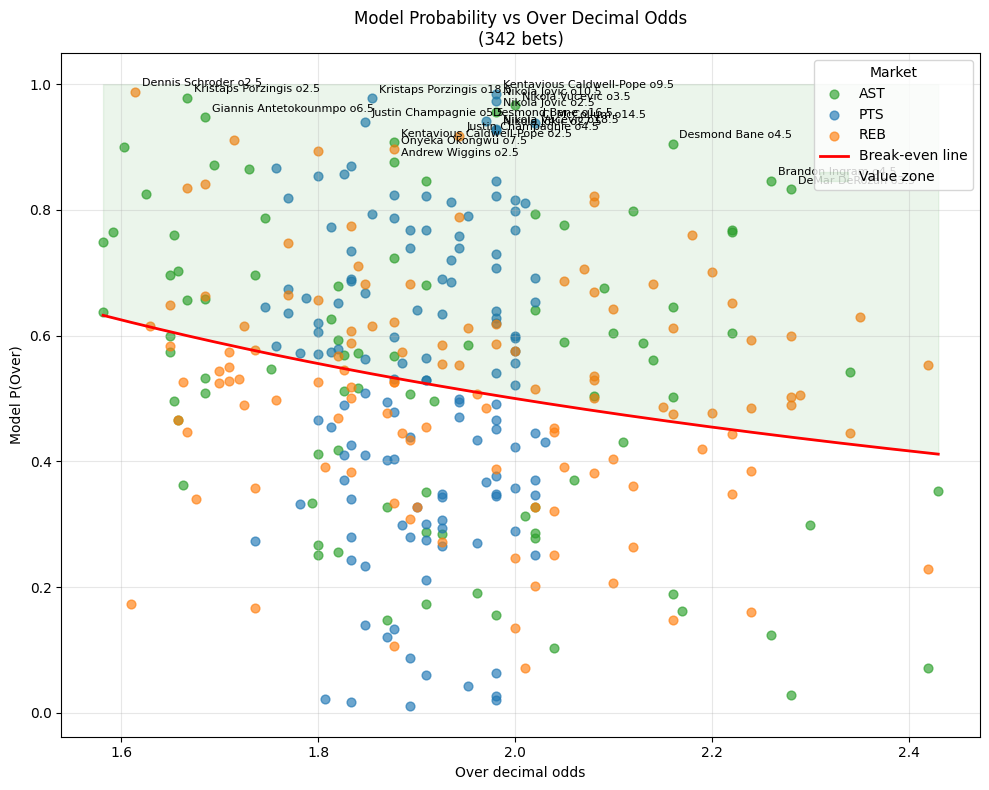

Saved: data/bets/visuals\prob_vs_decimal_20251107_104650.png


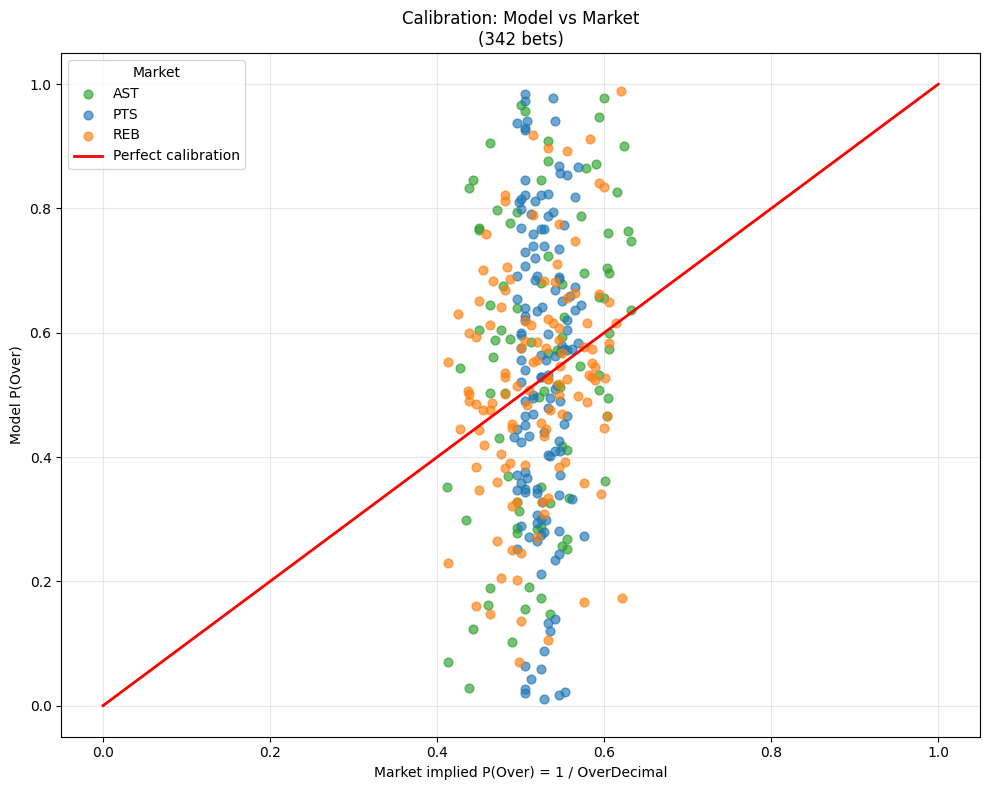

Saved: data/bets/visuals\calibration_20251107_104650.png


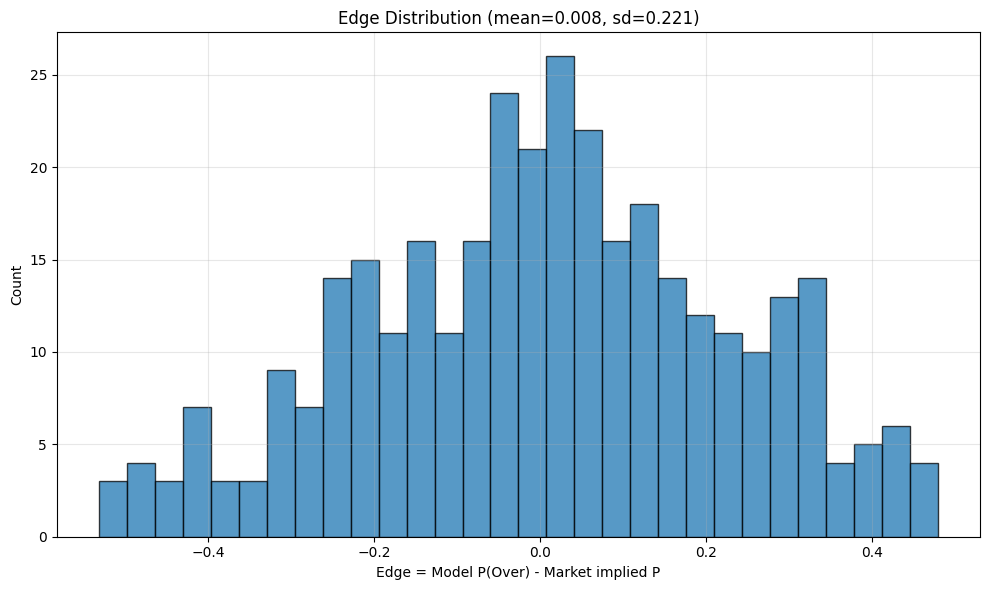

Saved: data/bets/visuals\edge_distribution_20251107_104650.png

Top 20 value bets (by edge):
                  Player Team Opponent Market   Line  OverDecimal  POverModel  p_over_price  edge_over  EV_over_1u
Kentavious Caldwell-Pope  MEM      DAL    PTS  9.500        1.980       0.984         0.505      0.479       0.949
            Nikola Jovic  MIA      CHA    PTS 10.500        1.980       0.973         0.505      0.468       0.928
          Nikola Vucevic  CHI     @MIL    AST  3.500        2.000       0.967         0.500      0.467       0.934
            Nikola Jovic  MIA      CHA    AST  2.500        1.980       0.956         0.505      0.451       0.894
             CJ McCollum  WAS      CLE    PTS 14.500        2.020       0.938         0.495      0.443       0.894
            Desmond Bane  ORL      BOS    AST  4.500        2.160       0.905         0.463      0.442       0.955
      Kristaps Porzingis  ATL      TOR    PTS 18.500        1.855       0.977         0.539      0.438

In [33]:
# === Visual diagnostics for model vs decimal odds (with market labels) ===
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Load latest decimal CSV ----------
cand = sorted(glob.glob("data/bets/value_bets_top100_*_decimal.csv"))
if not cand:
    cand = sorted(glob.glob("data/bets/value_bets_top100_*.csv"))
    if not cand:
        raise FileNotFoundError("No value bets file found in data/bets.")
path = cand[-1]
print(f"Using file: {path}")

df = pd.read_csv(path)

# ---------- Inspect columns ----------
print("All columns in CSV:", list(df.columns))

# ---------- Map column names (robustly) ----------
def find_col(df, candidates):
    cols_lc = {c.lower(): c for c in df.columns}
    for name in candidates:
        c = cols_lc.get(name.lower())
        if c: return c
    return None

col_player   = find_col(df, ["Player"])
col_team     = find_col(df, ["Team"])
col_opp      = find_col(df, ["Opponent"])
col_market   = find_col(df, ["Market"])
col_line     = find_col(df, ["Line", "line_dfD", "posted_line"])
col_p_model  = find_col(df, ["POverModel","p_over_model","P_over_model","pModel","p_model"])
col_over_dec = find_col(df, ["OverDecimal","over_dec","OverDec","OverDecimalOdds"])

required = [col_player, col_market, col_p_model, col_over_dec]
if any(x is None for x in required):
    missing = [n for n, x in zip(
        ["Player","Market","POverModel","OverDecimal"], required) if x is None]
    raise KeyError(f"Missing required columns: {missing}")

# ---------- Build working frame ----------
opt_cols = [col_team, col_opp, col_line, find_col(df, ["ProjMean"]), find_col(df, ["ProjSD"]), "ProjMins", "POverImp", "POverFair"]
keep = [c for c in [col_player, col_market, col_over_dec, col_p_model] + opt_cols if c and c in df.columns]
d = df[keep].copy()

# Coerce numerics (robust)
def _to_float(s):
    try:
        return float(s)
    except Exception:
        m = re.search(r"[-+]?\d+(?:\.\d+)?", str(s))
        return float(m.group()) if m else np.nan

for c in [col_over_dec, col_p_model, col_line] if col_line else [col_over_dec, col_p_model]:
    d[c] = d[c].apply(_to_float)

# ---------- Derived metrics ----------
d["p_over_price"] = 1.0 / d[col_over_dec]
d["edge_over"]    = d[col_p_model] - d["p_over_price"]
d["EV_over_1u"]   = d[col_p_model] * (d[col_over_dec] - 1.0) - (1.0 - d[col_p_model])

# Label like "Player o7.5"
def fmt_line(x):
    return "" if pd.isna(x) else f"{x:g}"
d["label"] = d.apply(
    lambda r: f"{r[col_player]} o{fmt_line(r[col_line])}" if col_line else f"{r[col_player]}",
    axis=1
)

# Filter usable rows
viz = d[
    d[col_over_dec].notna() &
    d[col_p_model].notna() &
    (d[col_over_dec] > 1.0) &
    (d[col_p_model].between(0.01, 0.99))
].copy()

print("Usable rows for visuals:", len(viz))
if viz.empty:
    print("No usable rows to visualize. Sample:")
    print(d.head(10))
else:
    # ---------- Output paths ----------
    outdir = "data/bets/visuals"
    os.makedirs(outdir, exist_ok=True)
    stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

    # ---------- Color by market ----------
    color_map = {"PTS": "C0", "REB": "C1", "AST": "C2"}
    fig, ax = plt.subplots(figsize=(10, 8))
    for mkt, grp in viz.groupby(col_market):
        ax.scatter(
            grp[col_over_dec], grp[col_p_model],
            alpha=0.65, s=40, label=mkt, c=color_map.get(str(mkt), "C3")
        )

    ax.set_xlabel("Over decimal odds")
    ax.set_ylabel("Model P(Over)")
    ax.set_title(f"Model Probability vs Over Decimal Odds\n({len(viz)} bets)")

    # Break-even curve & shaded "value zone"
    x_min = max(1.01, float(viz[col_over_dec].min()))
    x_max = float(viz[col_over_dec].max())
    x = np.linspace(x_min, x_max, 300)
    y = 1.0 / x
    ax.plot(x, y, color="red", linewidth=2, label="Break-even line")
    ax.fill_between(x, y, 1.0, color="green", alpha=0.08, label="Value zone")

    # Label top N by edge
    TOP_N_LABELS = 20
    to_label = viz.sort_values("edge_over", ascending=False).head(TOP_N_LABELS)
    for _, r in to_label.iterrows():
        ax.annotate(
            r["label"],
            (r[col_over_dec], r[col_p_model]),
            textcoords="offset points", xytext=(5, 4),
            fontsize=8, color="black"
        )

    ax.legend(loc="best", title="Market")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    scatter_path = os.path.join(outdir, f"prob_vs_decimal_{stamp}.png")
    fig.savefig(scatter_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", scatter_path)

    # ---------- Calibration plot ----------
    fig, ax = plt.subplots(figsize=(10, 8))
    viz_cal = viz.copy()
    viz_cal["p_market_over"] = 1.0 / viz_cal[col_over_dec]
    for mkt, grp in viz_cal.groupby(col_market):
        ax.scatter(
            grp["p_market_over"], grp[col_p_model],
            alpha=0.65, s=40, label=mkt, c=color_map.get(str(mkt), "C3")
        )
    ax.plot([0, 1], [0, 1], color="red", linewidth=2, label="Perfect calibration")
    ax.set_xlabel("Market implied P(Over) = 1 / OverDecimal")
    ax.set_ylabel("Model P(Over)")
    ax.set_title(f"Calibration: Model vs Market\n({len(viz_cal)} bets)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", title="Market")
    fig.tight_layout()
    calib_path = os.path.join(outdir, f"calibration_{stamp}.png")
    fig.savefig(calib_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", calib_path)

    # ---------- Edge distribution ----------
    edges = viz["edge_over"].dropna()
    if not edges.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(edges, bins=30, alpha=0.75, edgecolor="black")
        ax.set_xlabel("Edge = Model P(Over) - Market implied P")
        ax.set_ylabel("Count")
        ax.set_title(f"Edge Distribution (mean={edges.mean():.3f}, sd={edges.std():.3f})")
        ax.grid(True, alpha=0.3)
        fig.tight_layout()
        hist_path = os.path.join(outdir, f"edge_distribution_{stamp}.png")
        fig.savefig(hist_path, dpi=150, bbox_inches="tight")
        plt.show()
        print("Saved:", hist_path)

    # ---------- Top 20 preview + export ----------
    top = viz.sort_values("edge_over", ascending=False).head(50).copy()
    show_cols = [c for c in [
        col_player, col_team, col_opp, col_market, col_line,
        col_over_dec, col_p_model, "p_over_price", "edge_over", "EV_over_1u"
    ] if c in top.columns]
    print("\nTop 20 value bets (by edge):")
    if not top.empty:
        print(top.head(20)[show_cols].to_string(index=False,
              float_format=lambda x: f"{x:.3f}" if isinstance(x, float) else str(x)))
    outdir_csv = os.path.join("data/bets/visuals")
    os.makedirs(outdir_csv, exist_ok=True)
    top_path = os.path.join(outdir_csv, f"top_value_{stamp}.csv")
    top.to_csv(top_path, index=False)
    print("Saved ranked value table →", top_path)

print("\nVisualization complete. Check the 'data/bets/visuals' folder for results.")


Using: data/bets\value_bets_top100_20251107_decimal.csv


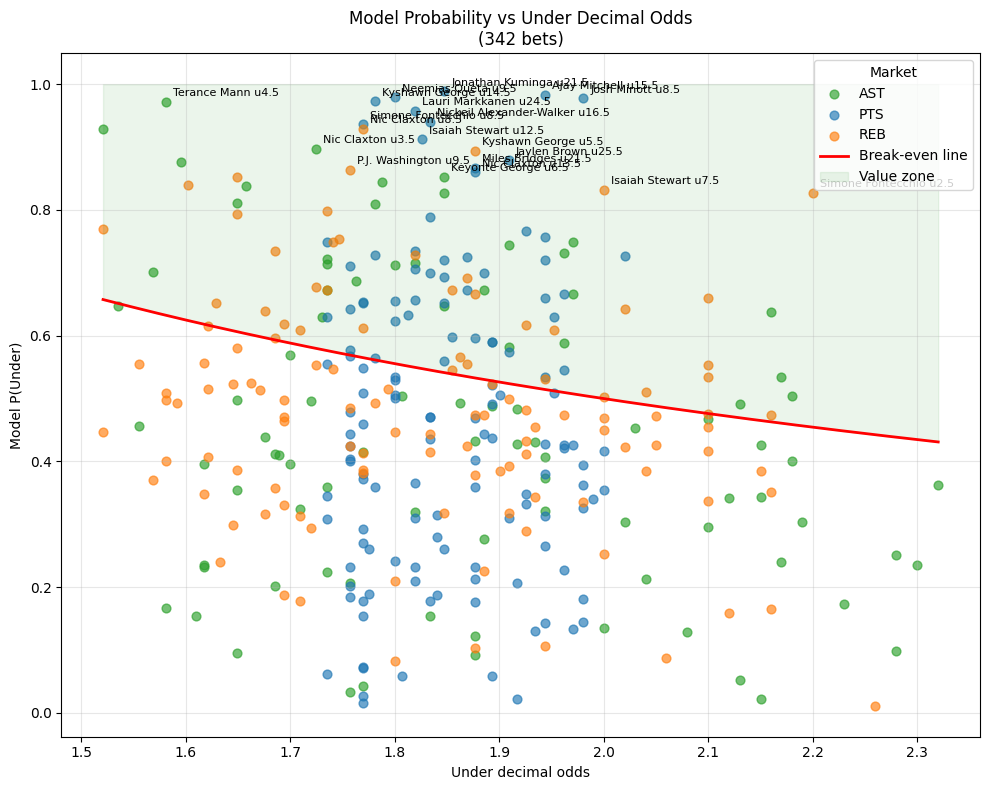

Saved: data/bets/visuals\prob_vs_under_decimal_20251107_104652.png


In [34]:
# === Visual: Model P(Under) vs Under Decimal Odds — color by market with legend (top 20 labels) ===
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------- 1) Load latest decimal bets file --------
cands = sorted(glob.glob("data/bets/value_bets_top100_*_decimal.csv"))
if not cands:
    cands = sorted(glob.glob("data/bets/value_bets_top100_*.csv"))
    if not cands:
        raise FileNotFoundError("No value bets files found in data/bets/")
path = cands[-1]
print("Using:", path)
df = pd.read_csv(path)

# -------- 2) Column resolution (tolerant to naming) --------
def find_col(dframe, names):
    cols = {re.sub(r"[\W_]+","", c).lower(): c for c in dframe.columns.astype(str)}
    for n in names:
        k = re.sub(r"[\W_]+","", n).lower()
        if k in cols: return cols[k]
    return None

col_player = find_col(df, ["Player"])
col_market = find_col(df, ["Market"])
col_line   = find_col(df, ["Line","line_dfD","posted_line","line"])
col_punder = find_col(df, ["PUnderModel","p_under_model"])
col_pover  = find_col(df, ["POverModel","p_over_model"])  # fallback to compute p_under
col_underD = find_col(df, ["UnderDecimal","under_dec","UnderDec","UnderDecimalOdds"])
col_underUS= find_col(df, ["UnderOdds_American","UnderOdds","under_odds"])  # for conversion if needed

# American → decimal (fallback)
def american_to_decimal(a):
    if pd.isna(a): return np.nan
    try:
        a = float(a)
    except Exception:
        m = re.search(r"[-+]?\d+(?:\.\d+)?", str(a))
        a = float(m.group()) if m else np.nan
    if pd.isna(a): return np.nan
    return 1.0 + (a/100.0) if a > 0 else 1.0 + (100.0/abs(a))

# Build UnderDecimal if missing
if col_underD is None and col_underUS is not None:
    df["UnderDecimal_fallback"] = df[col_underUS].map(american_to_decimal)
    col_underD = "UnderDecimal_fallback"

need = [col_player, col_market, col_line, col_underD]
miss = [n for n,v in zip(["Player","Market","Line","UnderDecimal"], need) if v is None]
if miss:
    raise KeyError(f"Missing required columns in file: {miss}")

# Canonicalize core columns
df = df.rename(columns={
    col_player:"player",
    col_market:"market",
    col_line:"line",
    col_underD:"under_dec",
})

# p_under_model: use direct column if present, else 1 - p_over_model
if col_punder:
    df = df.rename(columns={col_punder:"p_under_model"})
    df["p_under_model"] = pd.to_numeric(df["p_under_model"], errors="coerce")
elif col_pover:
    df["p_under_model"] = 1.0 - pd.to_numeric(df[col_pover], errors="coerce")
else:
    raise KeyError("Need either PUnderModel/p_under_model or POverModel/p_over_model to derive P(Under).")

# Ensure numeric types
for c in ["line","under_dec"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# -------- 3) Metrics & filter for plotting --------
df["p_under_price"] = 1.0 / df["under_dec"]
df["edge_under"]    = df["p_under_model"] - df["p_under_price"]

viz = df[
    df["under_dec"].notna() & (df["under_dec"] > 1.0) &
    df["p_under_model"].between(0.01, 0.99)
].copy()

if viz.empty:
    raise SystemExit("No usable rows to plot (need UnderDecimal>1 and valid PUnderModel).")

# Short label "Player u7.5"
def fmt_line(x):
    return "" if pd.isna(x) else f"{x:g}"
viz["label"] = viz.apply(lambda r: f"{r['player']} u{fmt_line(r['line'])}", axis=1)

# -------- 4) Scatter colored by market with legend (mirrors Over plot style) --------
MARKETS = ["PTS","REB","AST"]
color_map = {"PTS": "C0", "REB": "C1", "AST": "C2"}  # consistent with OVER plot

fig, ax = plt.subplots(figsize=(10, 8))
for mkt, grp in viz.groupby(viz["market"].astype(str).str.upper()):
    ax.scatter(
        grp["under_dec"], grp["p_under_model"],
        s=40, alpha=0.65, label=mkt, c=color_map.get(mkt, "C3")
    )

ax.set_xlabel("Under decimal odds")
ax.set_ylabel("Model P(Under)")
ax.set_title(f"Model Probability vs Under Decimal Odds\n({len(viz)} bets)")

# Break-even line and shaded "value zone" for UNDERS (y > 1/x)
x_min = max(1.01, float(viz["under_dec"].min()))
x_max = float(viz["under_dec"].max())
x = np.linspace(x_min, x_max, 300)
y = 1.0 / x
ax.plot(x, y, color="red", linewidth=2, label="Break-even line")
ax.fill_between(x, y, 1.0, color="green", alpha=0.08, label="Value zone")

# Label only the top 20 by edge_under
TOP_N_LABELS = 20
to_label = viz.sort_values("edge_under", ascending=False).head(TOP_N_LABELS)
for _, r in to_label.iterrows():
    ax.annotate(
        r["label"],
        (r["under_dec"], r["p_under_model"]),
        textcoords="offset points", xytext=(5, 4),
        fontsize=8, color="black"
    )

ax.legend(loc="best", title="Market")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# Save
outdir = "data/bets/visuals"
os.makedirs(outdir, exist_ok=True)
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(outdir, f"prob_vs_under_decimal_{stamp}.png")
fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


In [ ]:
# === EVALUATE YESTERDAY'S BETS (Europe/Athens) — model-driven suggestions (OVER/UNDER) ===
import os, re, glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# ------------------ settings: yesterday in Europe/Athens ------------------
TZ = ZoneInfo("Europe/Athens")
today_local = datetime.now(TZ).date()
ydate = today_local - timedelta(days=1)
ystr = ydate.strftime("%Y%m%d")
print(f"Evaluating bets for YESTERDAY (Europe/Athens): {ydate} ({ystr})")
print(f"Today is: {today_local}")

# where to save evaluation CSVs
os.makedirs("data/eval", exist_ok=True)

# ------------------ helpers ------------------
def _norm_player(s):
    if not isinstance(s, str): return ""
    return re.sub(r"[.`'’\-]", "", s.strip()).lower()

def pick_col(df, candidates, default=np.nan):
    for c in candidates:
        if c in df.columns:
            return df[c]
    return pd.Series([default]*len(df))

def _first_float(x):
    if pd.isna(x): return np.nan
    m = re.search(r"[-+]?\d+(?:\.\d+)?", str(x))
    return float(m.group()) if m else np.nan

def infer_opponent(df):
    if "OPPONENT_ABBREVIATION" in df.columns:
        return df["OPPONENT_ABBREVIATION"]
    matchup = pick_col(df, ["MATCHUP","Matchup"])
    team = pick_col(df, ["TEAM_ABBREVIATION","TEAM"])
    out = []
    for t, m in zip(team.fillna(""), matchup.fillna("")):
        opp = np.nan
        if isinstance(m, str) and m:
            parts = re.split(r"[@vVsS]+\.*", m)
            if len(parts) >= 2:
                cand = parts[-1].strip().upper()
                if cand == str(t).upper() and len(parts) >= 2:
                    cand = parts[0].strip().upper()
                opp = cand
        out.append(opp)
    return pd.Series(out, index=df.index)

def parse_date8_from_name(path):
    m = re.search(r"(20\d{6})", os.path.basename(path))
    return m.group(1) if m else None

# ------------------ 1) Find the bets file in data/bets with the requested structure ------------------
required_cols = {
    "Player","Team","Opponent","Market","Line",
    "OverOdds_American","UnderOdds_American","POverImp","PUnderImp",
    "POverFair","PUnderFair","ProjMins","ProjMean","ProjSD",
    "POverModel","PUnderModel","OverDecimal","UnderDecimal"
}

# Accept case-insensitive match and allow underscores vs camel
def has_required_columns(path):
    try:
        if path.lower().endswith(".csv"):
            head = pd.read_csv(path, nrows=0)
        else:
            with pd.ExcelFile(path) as xf:
                head = pd.read_excel(path, sheet_name=xf.sheet_names[0], nrows=0)
        cols_norm = {re.sub(r"[\W_]+", "", c).lower() for c in head.columns.astype(str)}
        need_norm = {re.sub(r"[\W_]+", "", c).lower() for c in required_cols}
        return need_norm.issubset(cols_norm)
    except Exception:
        return False

candidates = sorted(
    glob.glob("data/bets/*.csv") + glob.glob("data/bets/*.xlsx")
)

# Filter to files that have the required columns
candidates = [p for p in candidates if has_required_columns(p)]
if not candidates:
    raise FileNotFoundError(
        "No bets files in data/bets matching the required columns: "
        "Player, Team, Opponent, Market, Line, OverOdds_American, UnderOdds_American, "
        "POverImp, PUnderImp, POverFair, PUnderFair, ProjMins, ProjMean, ProjSD, "
        "POverModel, PUnderModel, OverDecimal, UnderDecimal"
    )

print(f"Found {len(candidates)} candidate files with required columns:")
for c in candidates:
    print(f"  - {os.path.basename(c)}")

# Look for bets file with the SAME date as yesterday
bets_path = None
for p in candidates:
    ds = parse_date8_from_name(p)
    if ds == ystr:  # Exact match for yesterday's date
        bets_path = p
        print(f"Found exact match for yesterday: {os.path.basename(bets_path)}")
        break

# If no exact match, use the most recent file BEFORE yesterday
if bets_path is None:
    dated_files = []
    for p in candidates:
        ds = parse_date8_from_name(p)
        if ds and ds <= ystr:  # Only consider files dated on or before yesterday
            dated_files.append((ds, p))
    
    if dated_files:
        dated_files.sort(key=lambda x: x[0])
        bets_path = dated_files[-1][1]  # Use the most recent one
        print(f"Warning: No bets file found for {ystr}. Using most recent available: {os.path.basename(bets_path)}")
    else:
        # Fallback to latest file (even if future dated)
        bets_path = candidates[-1]
        print(f"Warning: No dated bets files found. Using: {os.path.basename(bets_path)}")

print("Using bets file:", os.path.basename(bets_path))

# ------------------ 2) Load bets ------------------
if bets_path.lower().endswith(".csv"):
    bets = pd.read_csv(bets_path)
else:
    with pd.ExcelFile(bets_path) as xf:
        bets = pd.read_excel(bets_path, sheet_name=xf.sheet_names[0])

print(f"Loaded bets rows: {len(bets)}")

# Map to canonical names using EXACT column names from your file
cols = {c.lower(): c for c in bets.columns}
def col(name_variants):
    for v in name_variants:
        key = v.lower()
        if key in cols: return cols[key]
    return None

# Use the exact column names from your file
cn_player = col(["Player"])
cn_team   = col(["Team"])
cn_opp    = col(["Opponent"])
cn_mkt    = col(["Market"])
cn_line   = col(["Line"])
cn_pom    = col(["POverModel"])
cn_pum    = col(["PUnderModel"])
cn_od     = col(["OverDecimal"])
cn_ud     = col(["UnderDecimal"])

# Check for required columns
need = [cn_player, cn_team, cn_opp, cn_mkt, cn_line, cn_pom, cn_od, cn_ud]
if any(x is None for x in need):
    missing = [n for n, x in zip(
        ["Player","Team","Opponent","Market","Line","POverModel","OverDecimal","UnderDecimal"], need) if x is None]
    raise KeyError(f"Missing expected columns in bets file: {missing}")

# Rename columns to standard names for processing
bets = bets.rename(columns={
    cn_player: "player",
    cn_team: "team", 
    cn_opp: "opponent",
    cn_mkt: "market", 
    cn_line: "line",
    cn_pom: "p_over_model", 
    cn_pum: "p_under_model",
    cn_od: "over_dec", 
    cn_ud: "under_dec"
})

# Convert numeric columns
bets["line"] = pd.to_numeric(bets["line"], errors="coerce")
bets["p_over_model"] = pd.to_numeric(bets["p_over_model"], errors="coerce")
bets["p_under_model"] = pd.to_numeric(bets["p_under_model"], errors="coerce")
bets["over_dec"] = pd.to_numeric(bets["over_dec"], errors="coerce")
bets["under_dec"] = pd.to_numeric(bets["under_dec"], errors="coerce")

# Add key for joining to box scores
bets["player_key"] = bets["player"].map(_norm_player)

# ------------------ 3) Load boxscores for yesterday (from data_raw/) ------------------
BOXSCORE_DIR = "data_raw"

def load_boxscores_for_date(target_date):
    """Load boxscores for a specific date, handling various file naming patterns"""
    target_date_str = target_date.strftime("%Y%m%d")
    
    # Try multiple file patterns
    patterns = [
        f"nba_boxscores_{target_date_str}.csv",
        f"nba_boxscores_*{target_date_str}*.csv",
        "nba_boxscores_*.csv"  # season file
    ]
    
    for pattern in patterns:
        matches = glob.glob(os.path.join(BOXSCORE_DIR, pattern))
        if matches:
            # Use the most recent file if multiple matches
            box_file = sorted(matches)[-1]
            box = pd.read_csv(box_file)
            print(f"Loaded boxscores from: {os.path.basename(box_file)}")
            
            # Filter to target date
            date_cols = ["GAME_DATE", "GAME_DATE_EST", "GAME_DATE_LCL", "Date", "date"]
            for date_col in date_cols:
                if date_col in box.columns:
                    box_dates = pd.to_datetime(box[date_col], errors='coerce').dt.date
                    filtered = box[box_dates == target_date].copy()
                    if len(filtered) > 0:
                        print(f"Filtered to {target_date} using column '{date_col}': {len(filtered)} rows")
                        return filtered
            
            # If no date filtering worked but we have data, return all
            if len(box) > 0:
                print(f"Warning: Could not filter by date. Using all {len(box)} rows.")
                return box
    
    raise FileNotFoundError(f"No boxscore data found for {target_date}")

try:
    box = load_boxscores_for_date(ydate)
except FileNotFoundError as e:
    print(e)
    # Create empty evaluation file
    eval_out = os.path.join("data/eval", f"value_bets_eval_{ystr}.csv")
    bets.assign(
        actual=np.nan, suggestion="NO BET", suggested_prob=np.nan, result_model="NA"
    ).to_csv(eval_out, index=False)
    print(f"Saved empty evaluation to: {eval_out}")
    raise SystemExit

# ------------------ 4) Normalize box & join ------------------
box = box.copy()
box["player"] = pick_col(box, ["PLAYER_NAME","Player"])
box["player_key"] = box["player"].map(_norm_player)
box["PTS"] = pd.to_numeric(pick_col(box, ["PTS","Points"]), errors="coerce")
box["REB"] = pd.to_numeric(pick_col(box, ["REB","Rebounds"]), errors="coerce")
box["AST"] = pd.to_numeric(pick_col(box, ["AST","Assists"]), errors="coerce")
box["TEAM_ABBREVIATION"] = pick_col(box, ["TEAM_ABBREVIATION","TEAM"])
box["OPPONENT_ABBREVIATION"] = infer_opponent(box)

joined = bets.merge(
    box[["player_key","PTS","REB","AST","TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"]],
    on="player_key", how="left", suffixes=("","_box")
)

def pick_actual(row):
    m = str(row.get("market","")).upper()
    return row.get(m, np.nan) if m in ["PTS","REB","AST"] else np.nan

joined["actual"] = joined.apply(pick_actual, axis=1)

# ------------------ 5) Model suggestion & grading ------------------
THRESH = 0.59  # model-confidence threshold

def suggest_side(row):
    po = row.get("p_over_model", np.nan)
    pu = row.get("p_under_model", np.nan)
    # If both are NaN → NO BET
    if pd.isna(po) and pd.isna(pu):
        return "NO BET", np.nan
    # Determine which side meets threshold and pick the higher prob if both do
    cand = []
    if pd.notna(po) and po >= THRESH:
        cand.append(("OVER", float(po)))
    if pd.notna(pu) and pu >= THRESH:
        cand.append(("UNDER", float(pu)))
    if not cand:
        return "NO BET", max([v for v in [po, pu] if pd.notna(v)] + [np.nan])
    # pick the larger probability among the qualifying sides
    cand.sort(key=lambda x: x[1], reverse=True)
    return cand[0]

joined[["suggestion","suggested_prob"]] = joined.apply(
    lambda r: pd.Series(suggest_side(r)), axis=1
)

def grade_row(row):
    side = row.get("suggestion", "NO BET")
    act  = row.get("actual", np.nan)
    line = row.get("line", np.nan)
    if side == "NO BET" or pd.isna(act) or pd.isna(line):
        return "NA"
    if side == "OVER":
        if act > line:  return "WIN"
        if act == line: return "PUSH"
        return "LOSS"
    if side == "UNDER":
        if act < line:  return "WIN"
        if act == line: return "PUSH"
        return "LOSS"
    return "NA"

joined["result_model"] = joined.apply(grade_row, axis=1)

# ------------------ 6) Summary & save ------------------
is_bet = joined["suggestion"].isin(["OVER","UNDER"])
graded = joined.loc[is_bet & joined["result_model"].isin(["WIN","LOSS","PUSH"])]

wins   = (graded["result_model"]=="WIN").sum()
losses = (graded["result_model"]=="LOSS").sum()
pushes = (graded["result_model"]=="PUSH").sum()
hitrate = wins / max(wins+losses, 1)

print(f"Suggested bets (THRESH={THRESH:.2f}): {is_bet.sum()} of {len(joined)} rows")
print(f"Graded bets: {len(graded)}  (WIN={wins}, LOSS={losses}, PUSH={pushes})")
print(f"Hit rate (excl. pushes): {hitrate:.1%}")

# Side-specific breakdown
graded_over  = graded.loc[joined["suggestion"]=="OVER"]
graded_under = graded.loc[joined["suggestion"]=="UNDER"]
def _rate(g):
    w = (g["result_model"]=="WIN").sum()
    l = (g["result_model"]=="LOSS").sum()
    return w / max(w+l,1)

print(f"OVER bets graded:  {len(graded_over)}  | Hit: {_rate(graded_over):.1%}")
print(f"UNDER bets graded: {len(graded_under)} | Hit: {_rate(graded_under):.1%}")

eval_out = os.path.join("data/eval", f"value_bets_eval_{ystr}.csv")
joined.to_csv(eval_out, index=False)
print(f"Saved evaluation to: {eval_out}")

# Preview a few rows with the actual column names from your file
cols_preview = [
    "player","team","opponent","market","line","actual",
    "p_over_model","p_under_model","over_dec","under_dec",
    "suggestion","suggested_prob","result_model",
    "TEAM_ABBREVIATION","OPPONENT_ABBREVIATION"
]
print("\nPreview:")
print(joined[ [c for c in cols_preview if c in joined.columns] ].head(25).to_string(index=False))

Evaluating bets for YESTERDAY (Europe/Athens): 2025-11-06 (20251106)
Today is: 2025-11-07
Found 1 candidate files with required columns:
  - value_bets_top100_20251104_decimal.csv
Using bets file: value_bets_top100_20251104_decimal.csv
Loaded bets rows: 242
Loaded boxscores from: nba_boxscores_2025-26.csv
Filtered to 2025-11-06 using column 'GAME_DATE': 26 rows
Suggested bets (THRESH=0.59): 164 of 242 rows
Graded bets: 29  (WIN=14, LOSS=15, PUSH=0)
Hit rate (excl. pushes): 48.3%
OVER bets graded:  21  | Hit: 42.9%
UNDER bets graded: 8 | Hit: 62.5%
Saved evaluation to: data/eval\value_bets_eval_20251106.csv

Preview:
            player team opponent market  line  actual  p_over_model  p_under_model  over_dec  under_dec suggestion  suggested_prob result_model TEAM_ABBREVIATION OPPONENT_ABBREVIATION
          AJ Green  MIL     @TOR    AST   1.5     NaN      0.540232       0.459768  2.000000   1.740741     NO BET        0.540232           NA               NaN                   NaN
        

In [40]:
import pandas as pd

# Load feature importance file
fi = pd.read_csv("model_outputs_rate/feature_importances_20251106_140212.csv")

# Preview to see what columns exist
print(fi.head())

# Normalize and compute mean importance
cols = [c for c in fi.columns if "importance" in c.lower()]
fi["mean_importance"] = fi[cols].mean(axis=1)
fi = fi.sort_values("mean_importance", ascending=False)

# Show top & bottom
print("🏆 Top 20 most important features:")
print(fi.head(20).to_string(index=False))

print("\n🪶 Bottom 20 least important features:")
print(fi.tail(20).to_string(index=False))


  stat       feature  importance  importance_norm
0  AST     AST_roll5    0.581291         0.296811
1  AST    AST_roll10    0.430663         0.219900
2  AST    MIN_roll10    0.103453         0.052824
3  AST  ORtg_g_roll5    0.083792         0.042785
4  AST    REB_roll10    0.065035         0.033207
🏆 Top 20 most important features:
stat           feature  importance  importance_norm  mean_importance
 PTS              USG%    7.813431         0.518598         4.166015
 REB        REB_roll10    0.926446         0.230584         0.578515
 PTS      ORtg_g_roll5    0.839228         0.055702         0.447465
 AST         AST_roll5    0.581291         0.296811         0.439051
 PTS               PER    0.752216         0.049927         0.401071
 PTS               TS%    0.745617         0.049489         0.397553
 PTS         PTS_roll5    0.668271         0.044355         0.356313
 AST        AST_roll10    0.430663         0.219900         0.325282
 REB         REB_roll5    0.465336         0.

In [41]:
low_importance = fi[fi["mean_importance"] < 0.001]["feature"].tolist()
medium_importance = fi[fi["mean_importance"].between(0.001, 0.005)]["feature"].tolist()
high_importance = fi[fi["mean_importance"] >= 0.005]["feature"].tolist()

print(f"Drop candidates ({len(low_importance)}): {low_importance}")
print(f"Keep ({len(high_importance)}): {high_importance[:15]} ...")


Drop candidates (0): []
Keep (66): ['USG%', 'REB_roll10', 'ORtg_g_roll5', 'AST_roll5', 'PER', 'TS%', 'PTS_roll5', 'AST_roll10', 'REB_roll5', 'MIN_roll10', 'PER', 'usage_share_roll5', 'Pace_g_roll5', 'BPM', 'MIN_roll5'] ...
